Lendo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv
Formato: (64800, 59)

Colunas ID-like (excluídas de análises): ['person_id', 'total_claims_paid', 'kidney_disease', 'provider_quality', 'cost_id', 'policy_id', 'record_id', 'visit_id']
Numéricas: ['annual_medical_cost', 'annual_premium', 'monthly_premium', 'claims_count', 'avg_claim_amount', 'hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease'] ...
Categóricas: ['plan_type', 'network_tier', 'sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'smoker', 'alcohol_freq'] ...

Alvo selecionado: annual_medical_cost


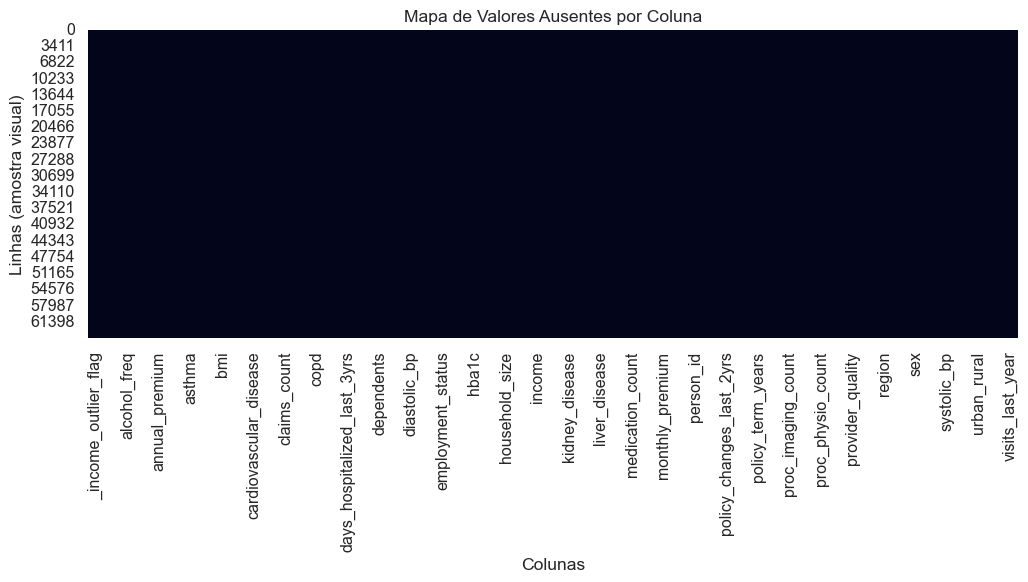

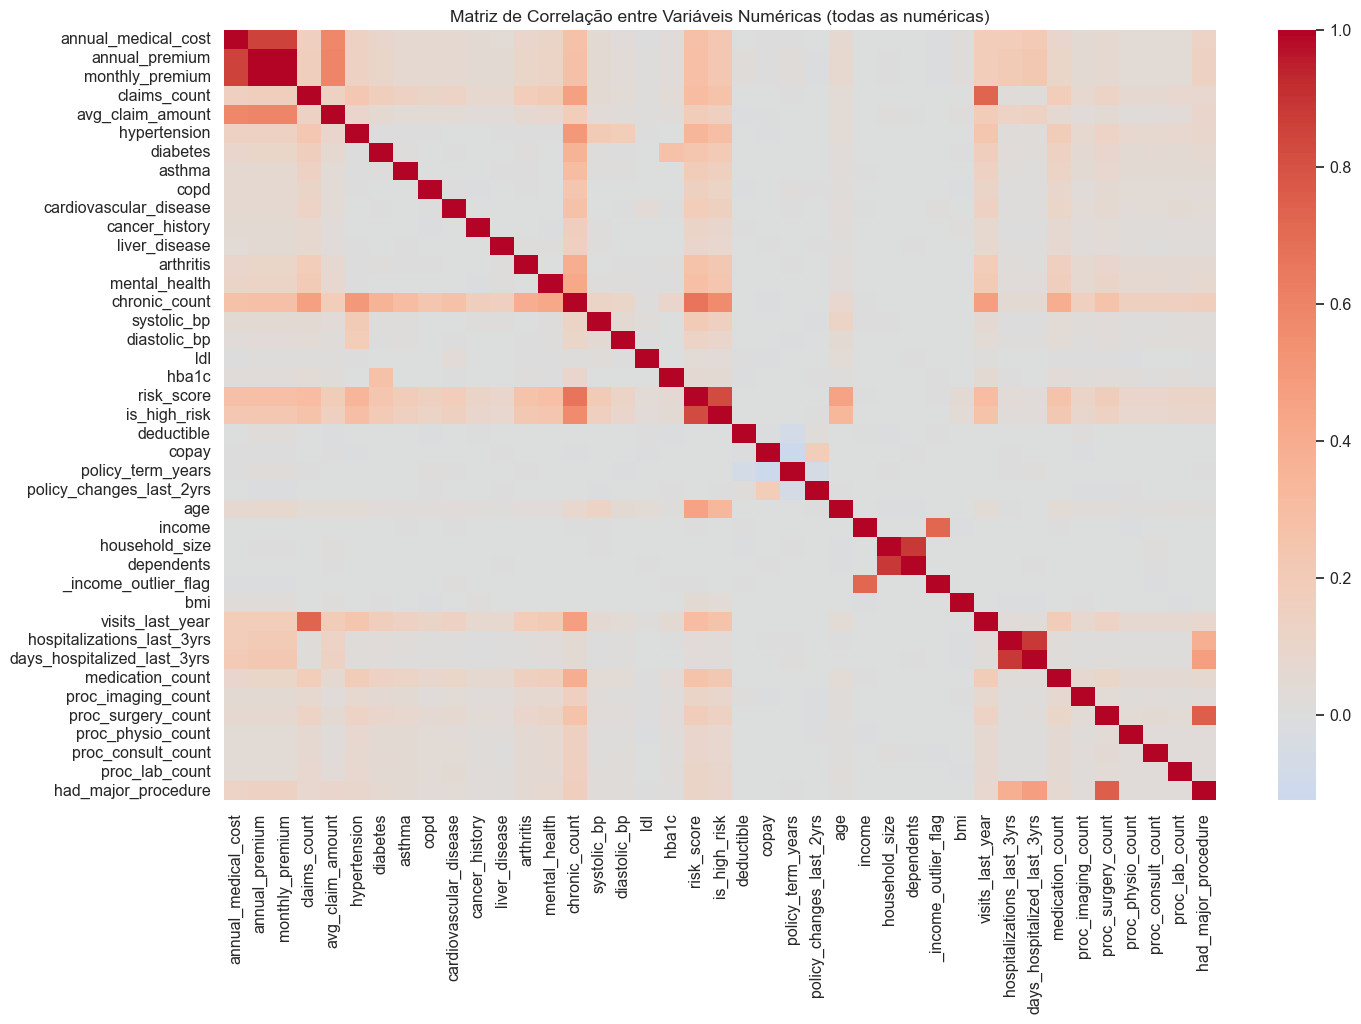


Top correlações absolutas com o alvo: annual_medical_cost
annual_premium                 0.855609
monthly_premium                0.855609
avg_claim_amount               0.578975
risk_score                     0.276581
chronic_count                  0.269804
is_high_risk                   0.227714
days_hospitalized_last_3yrs    0.207844
hospitalizations_last_3yrs     0.187048
visits_last_year               0.179127
claims_count                   0.161566
hypertension                   0.142044
had_major_procedure            0.133307
mental_health                  0.116688
medication_count               0.103851
diabetes                       0.100780
Name: annual_medical_cost, dtype: float64


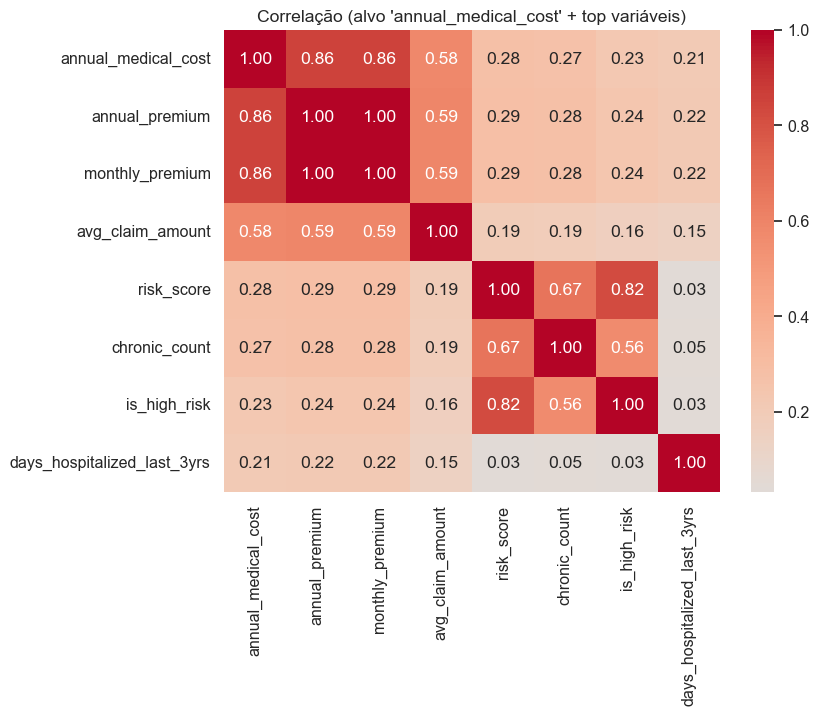

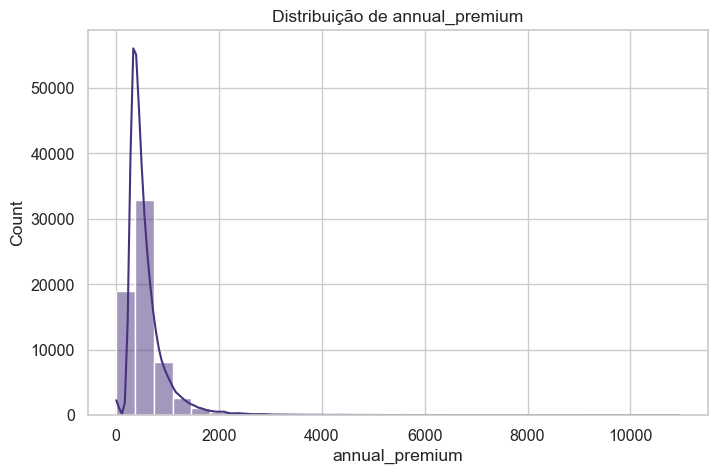

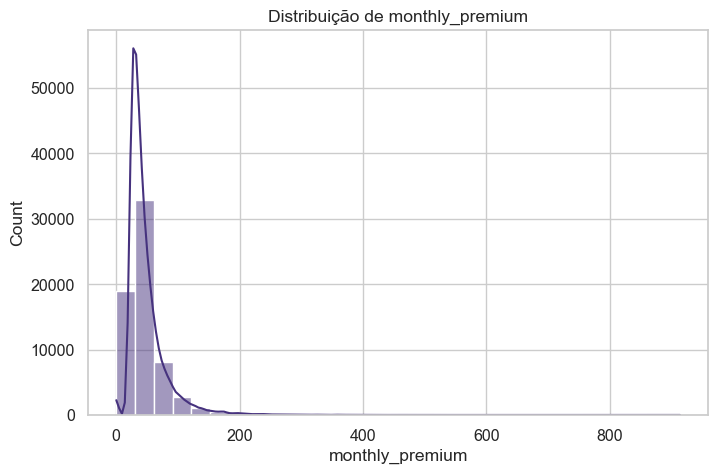

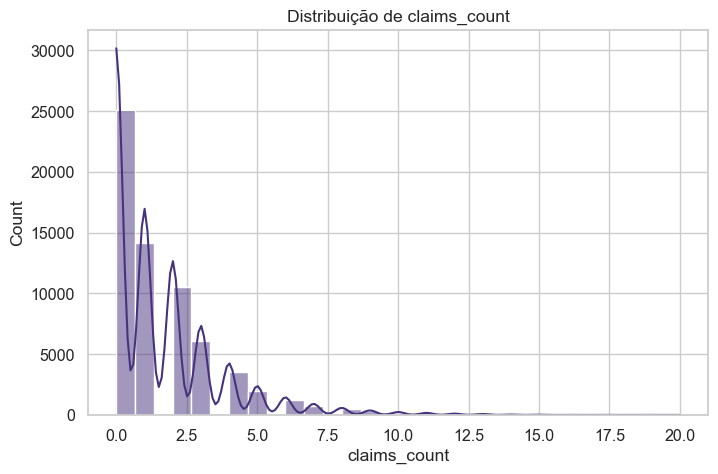

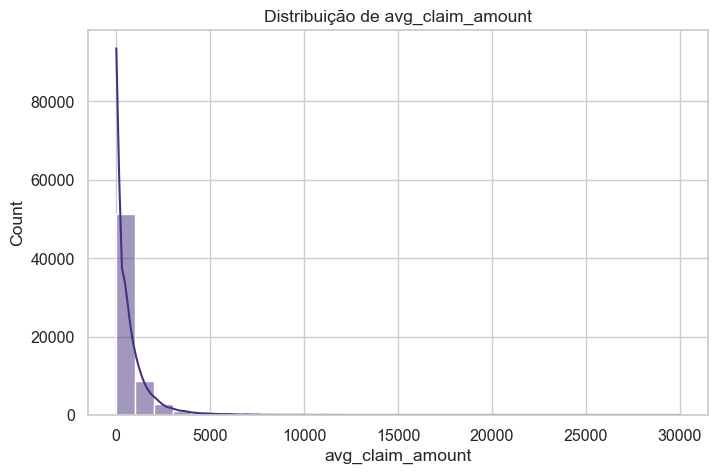

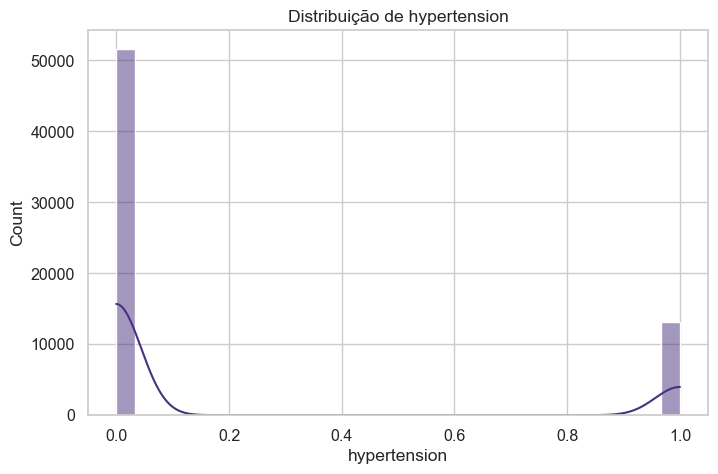

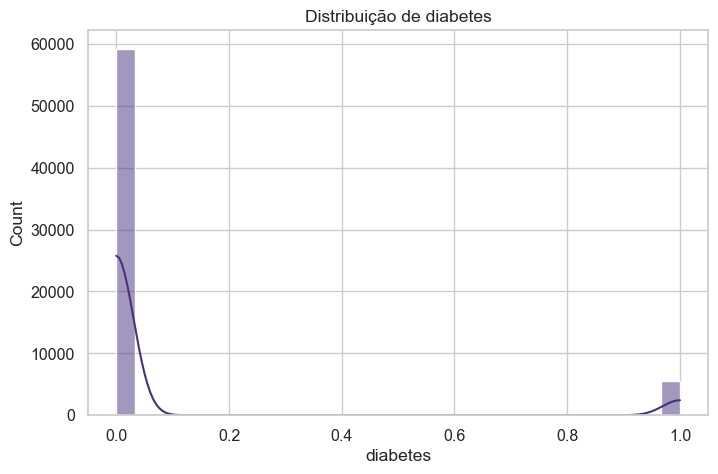

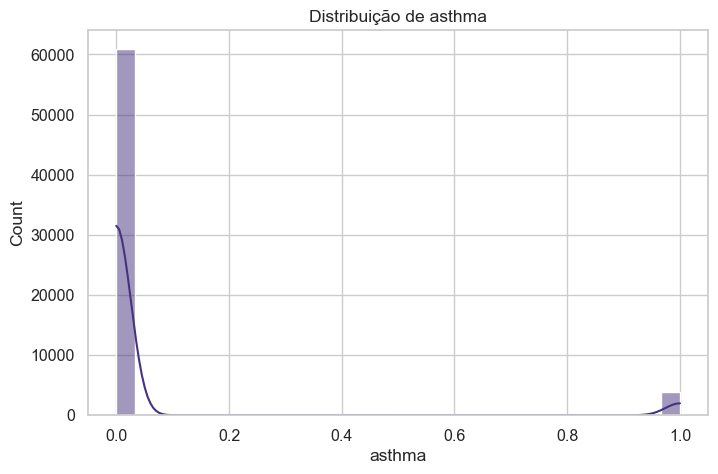

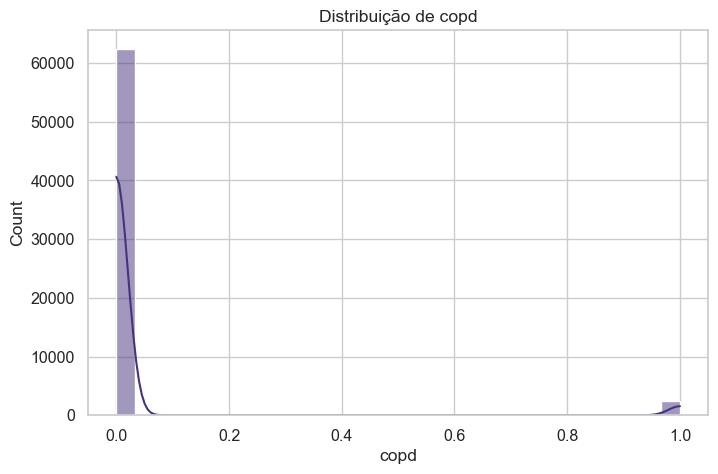

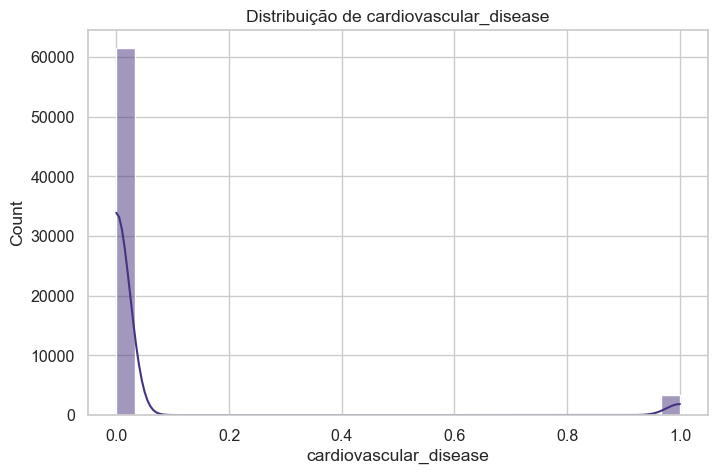

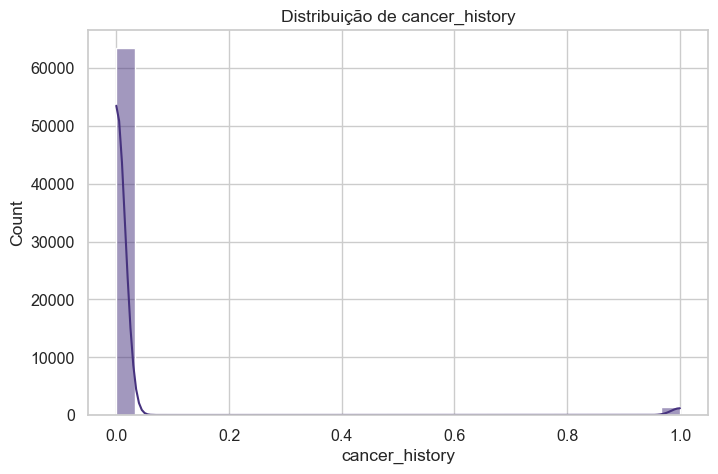

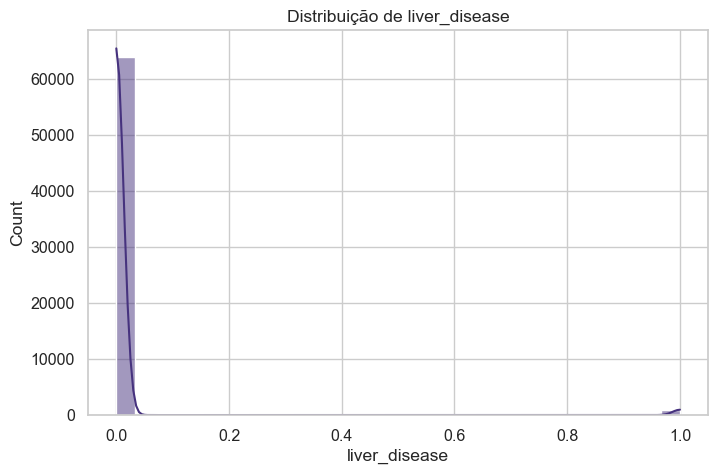

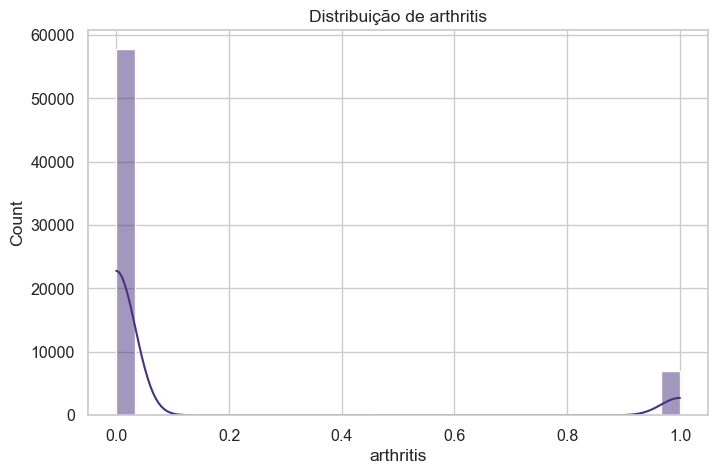

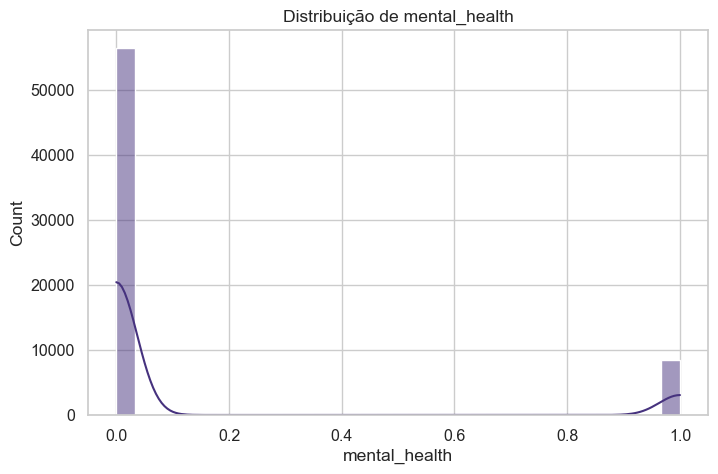

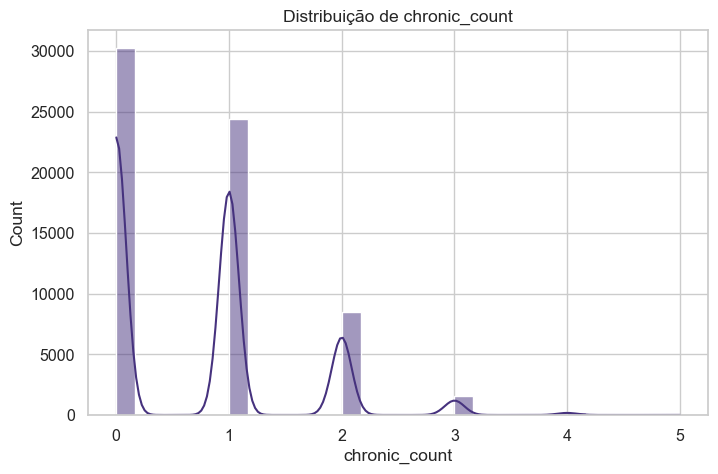

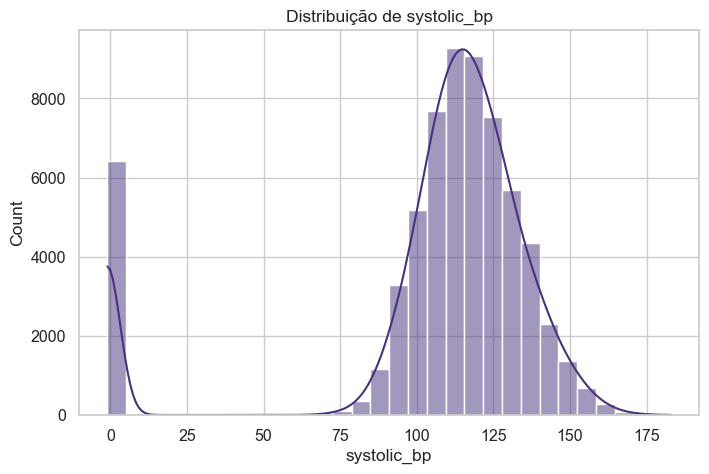

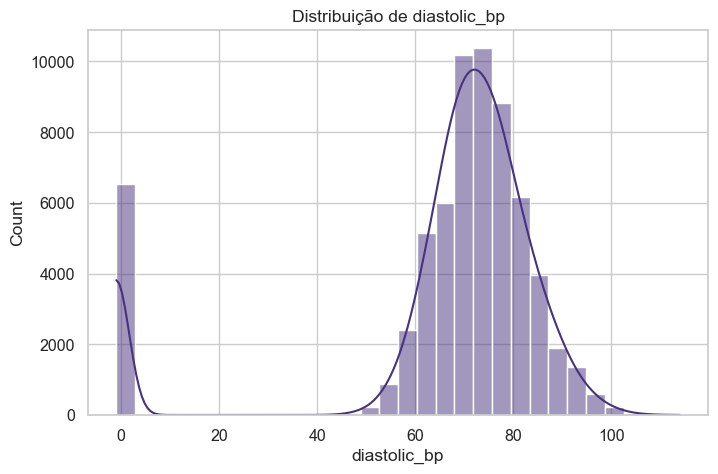

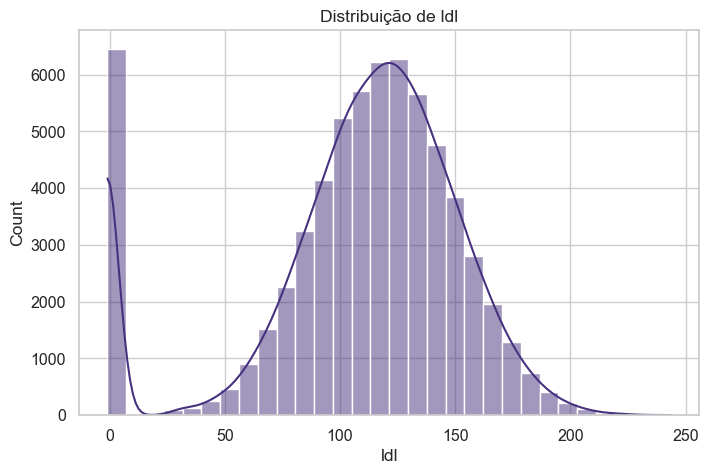

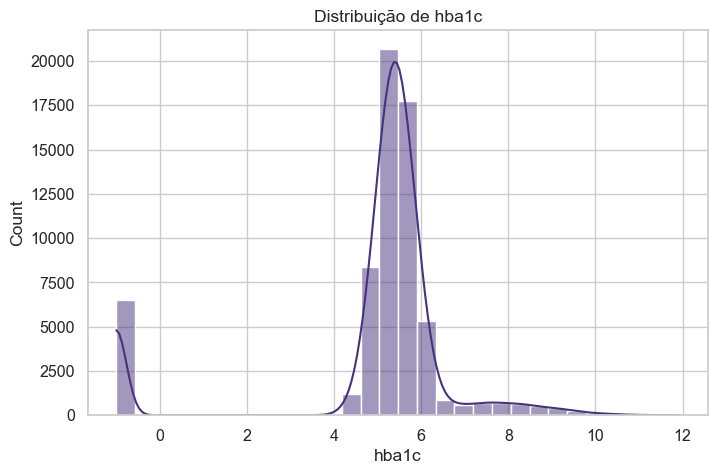

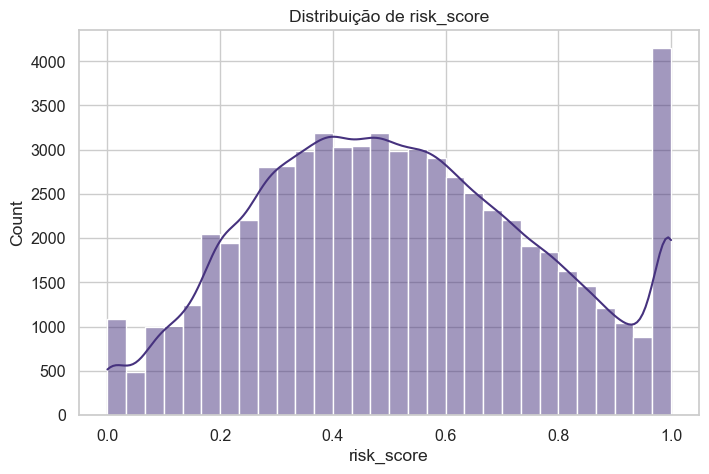

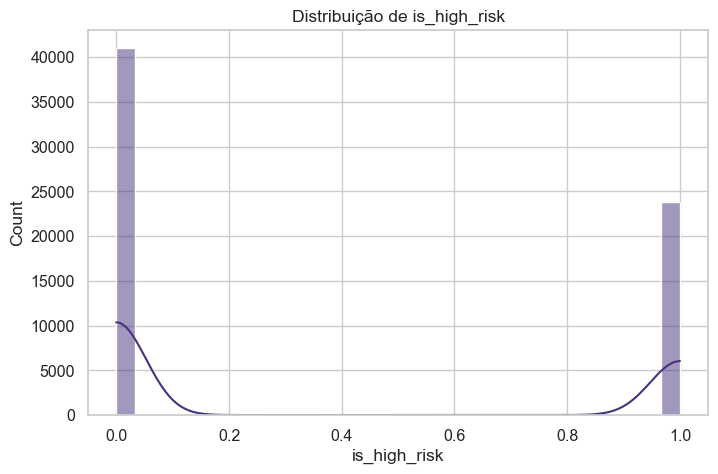

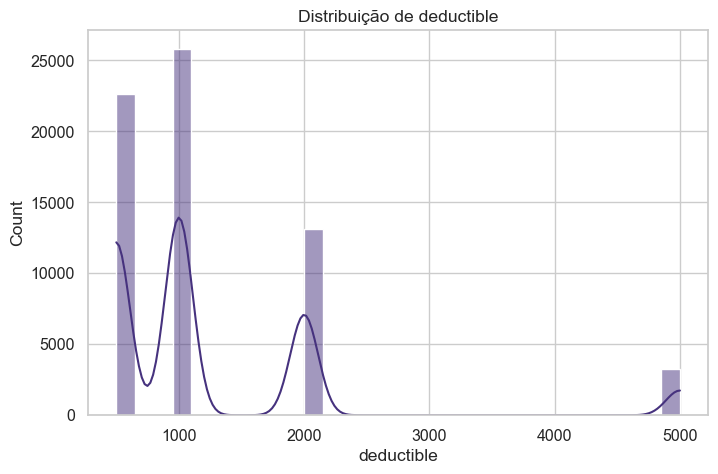

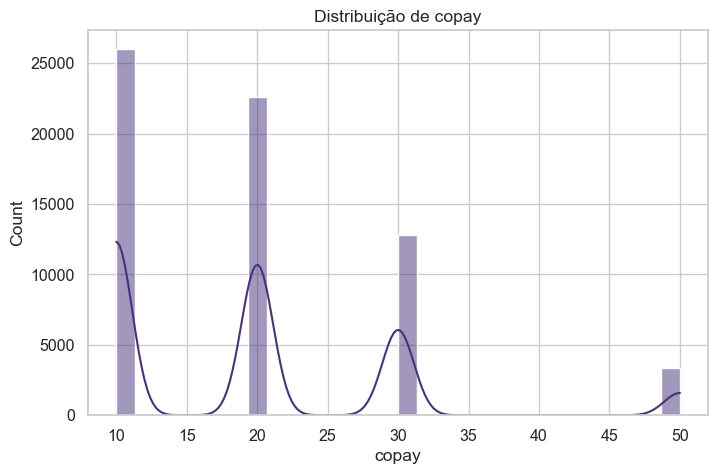

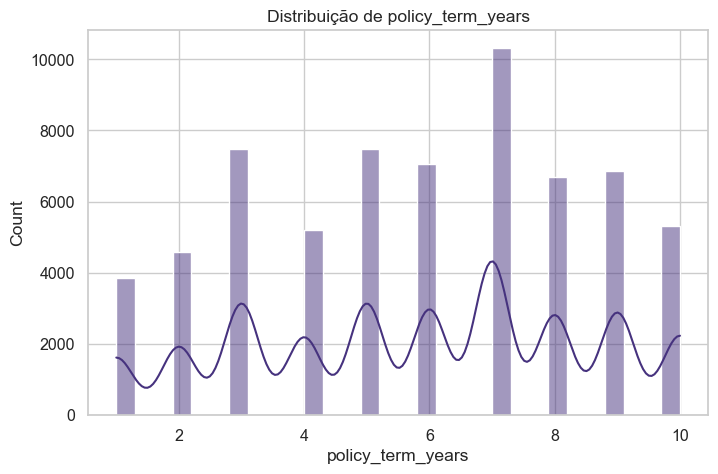

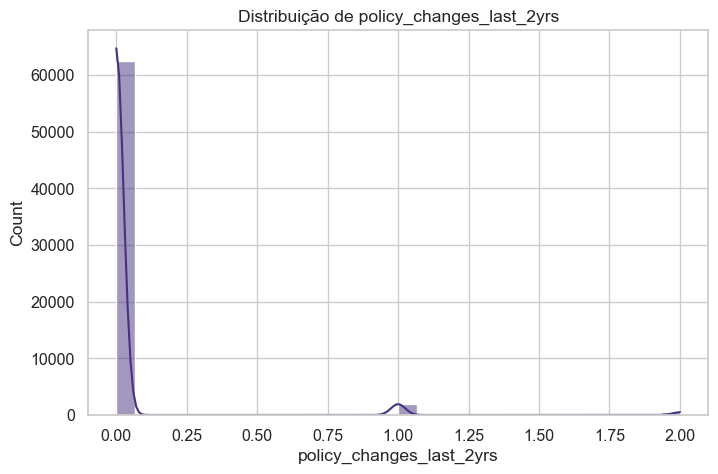

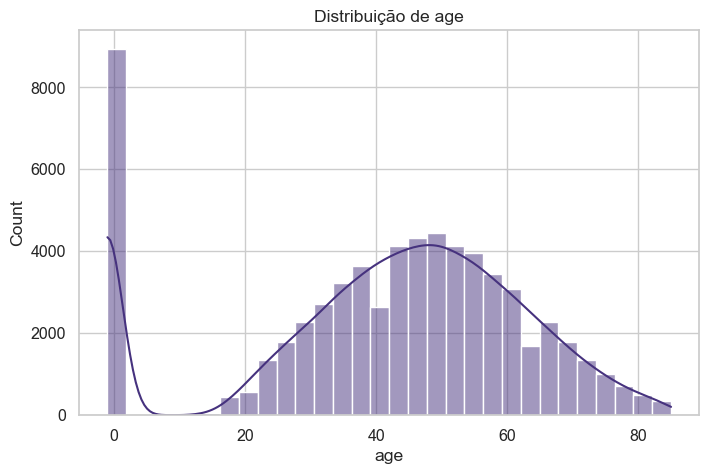

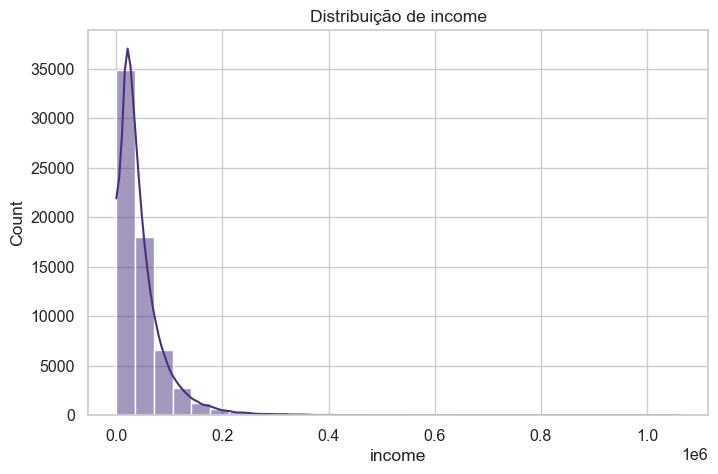

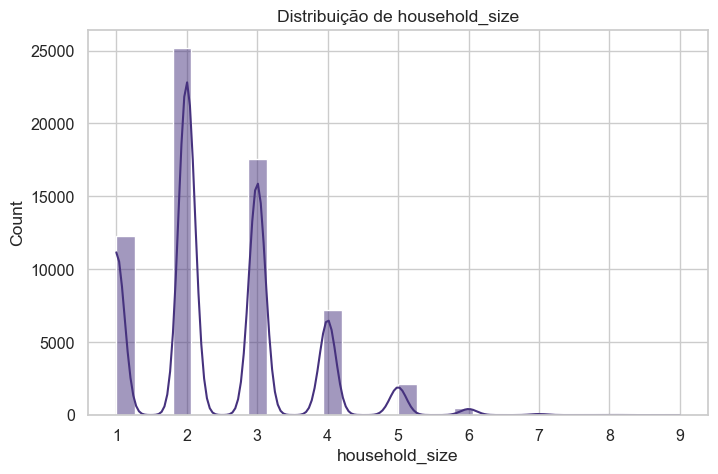

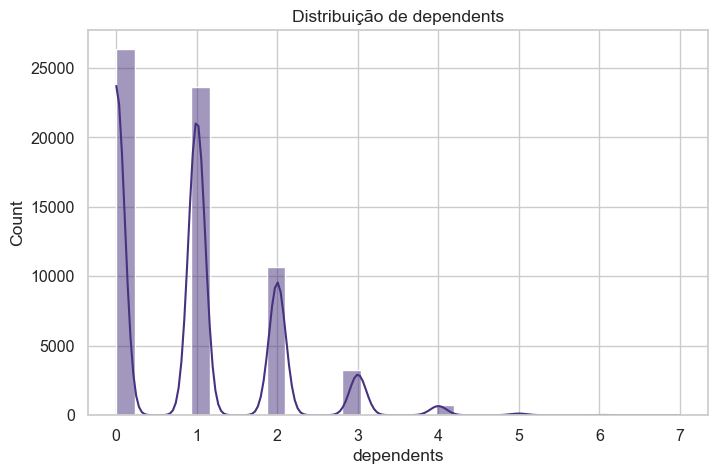

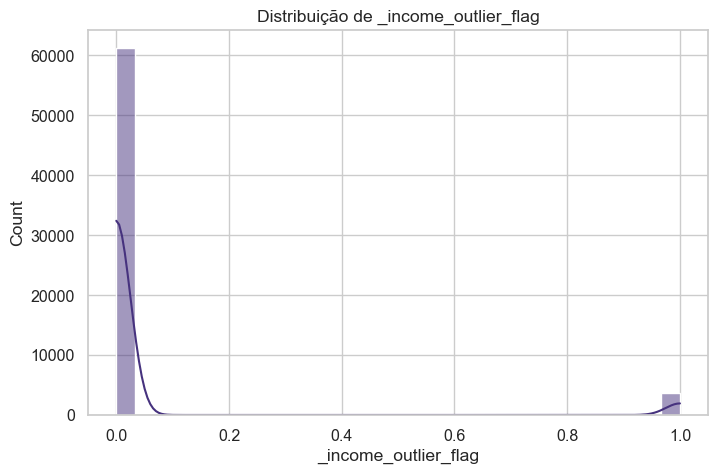

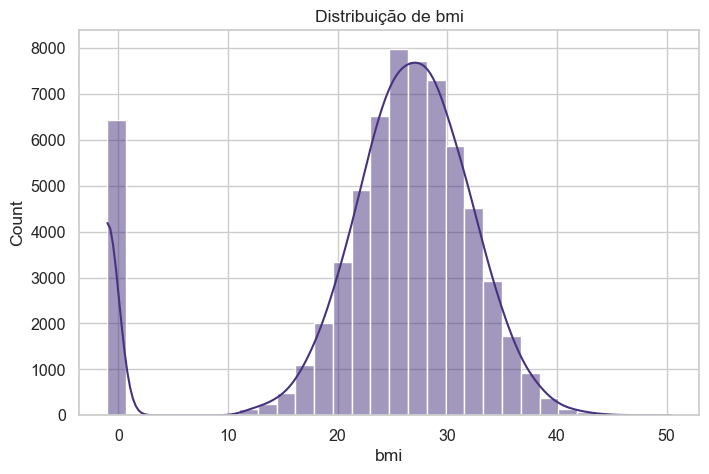

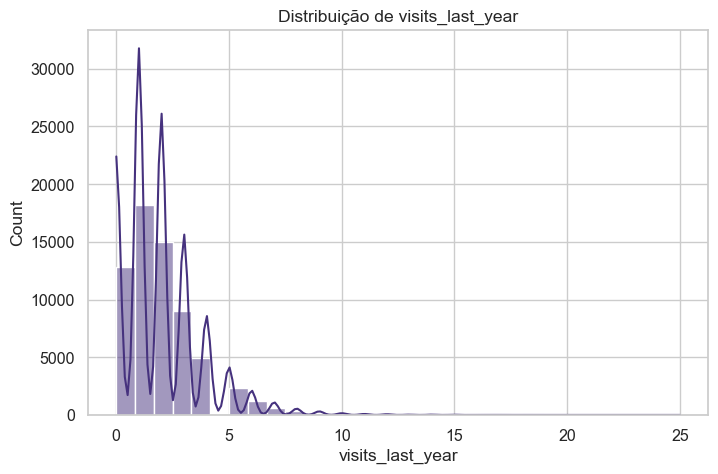

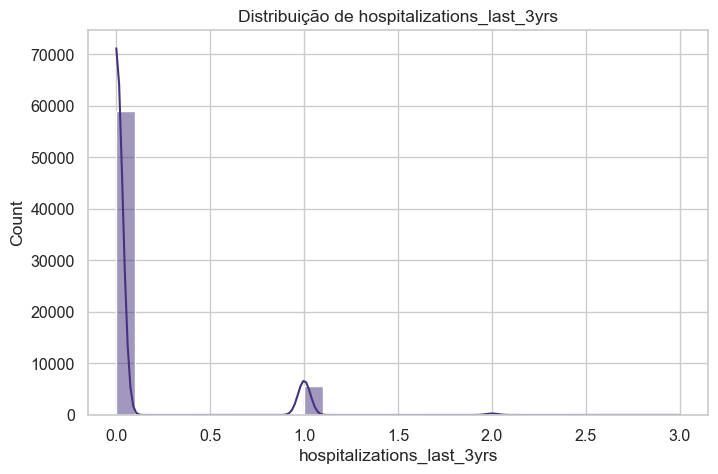

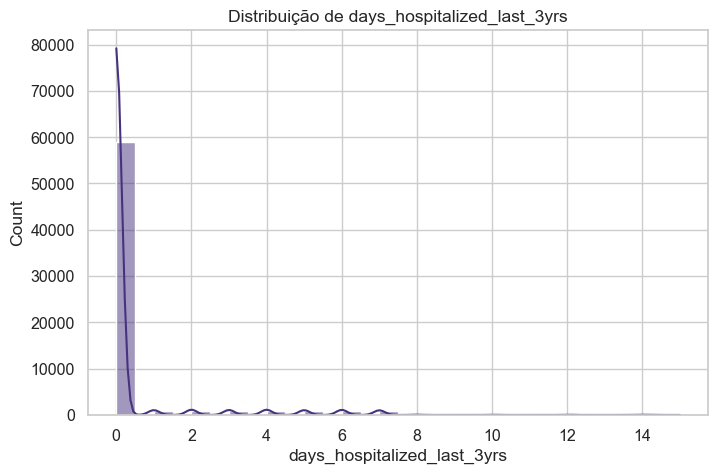

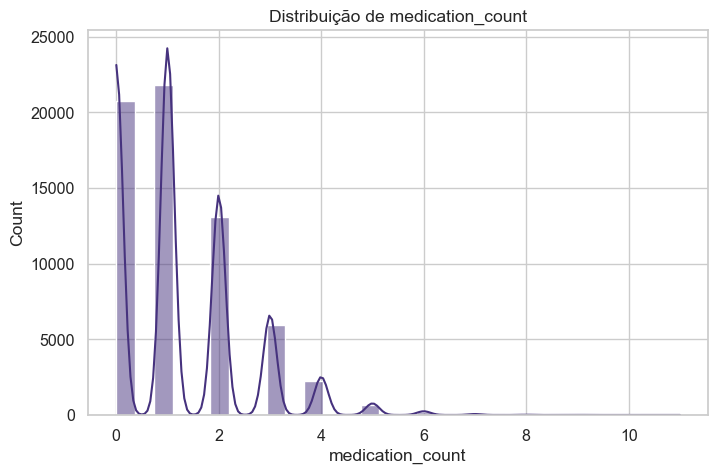

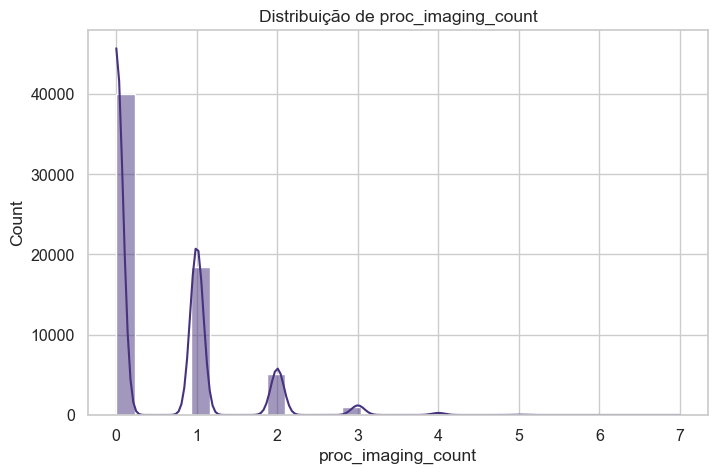

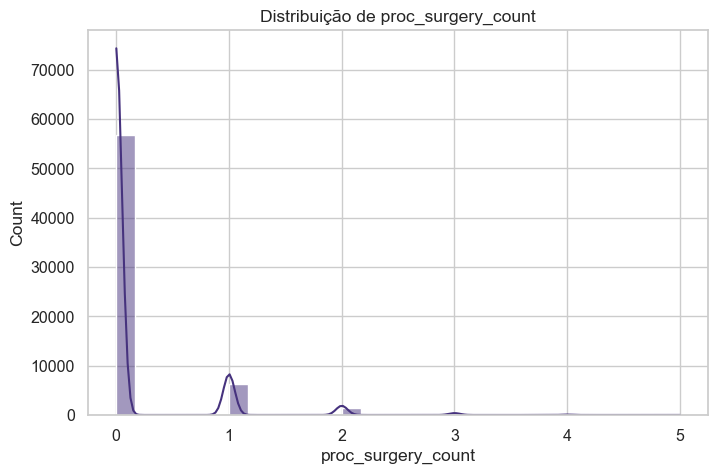

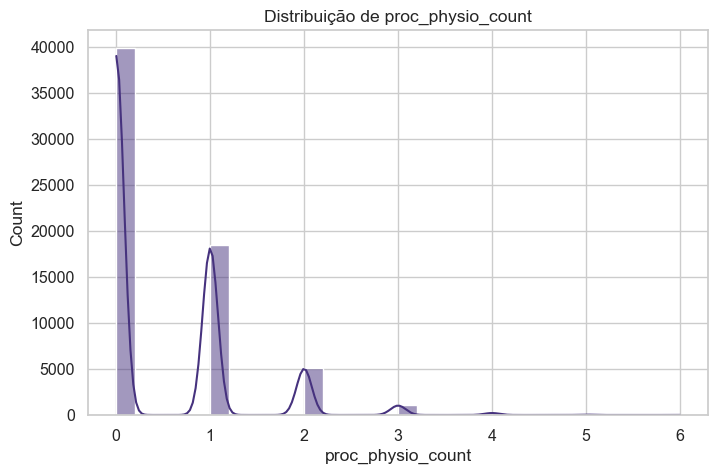

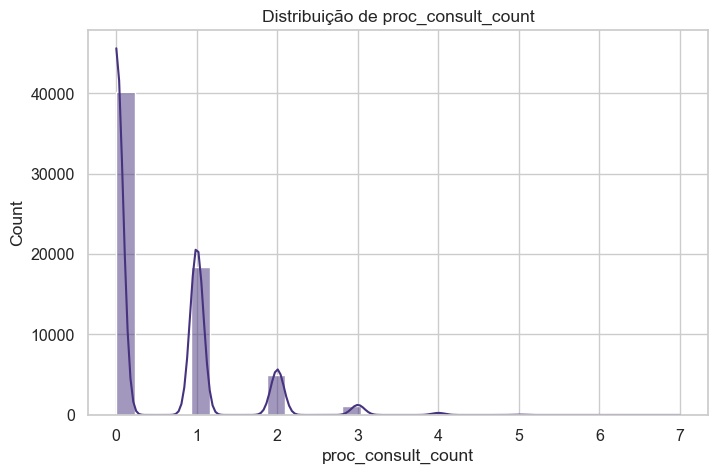

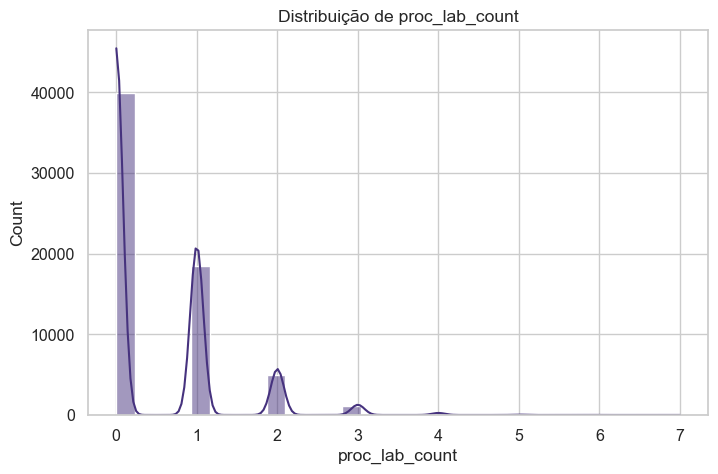

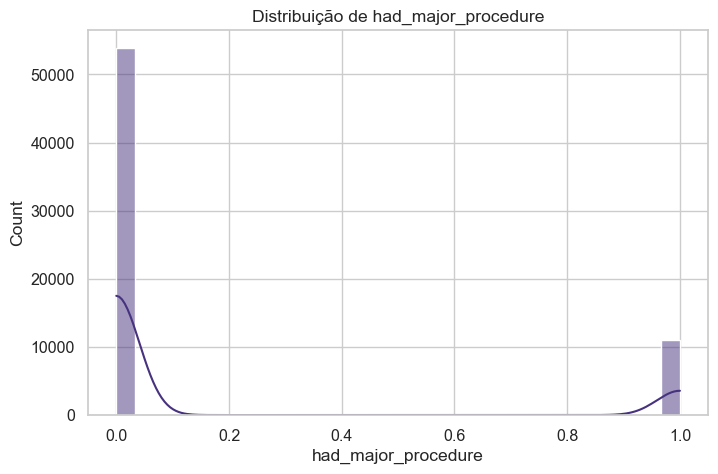

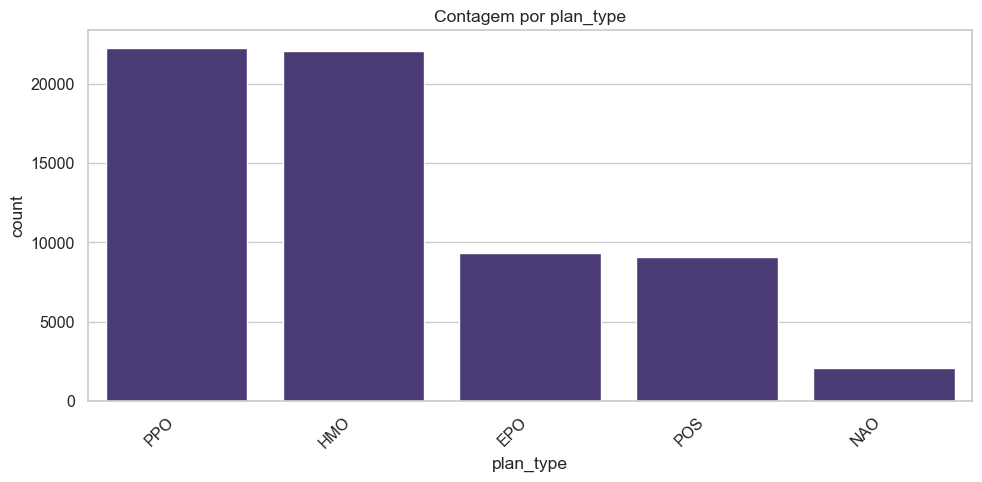

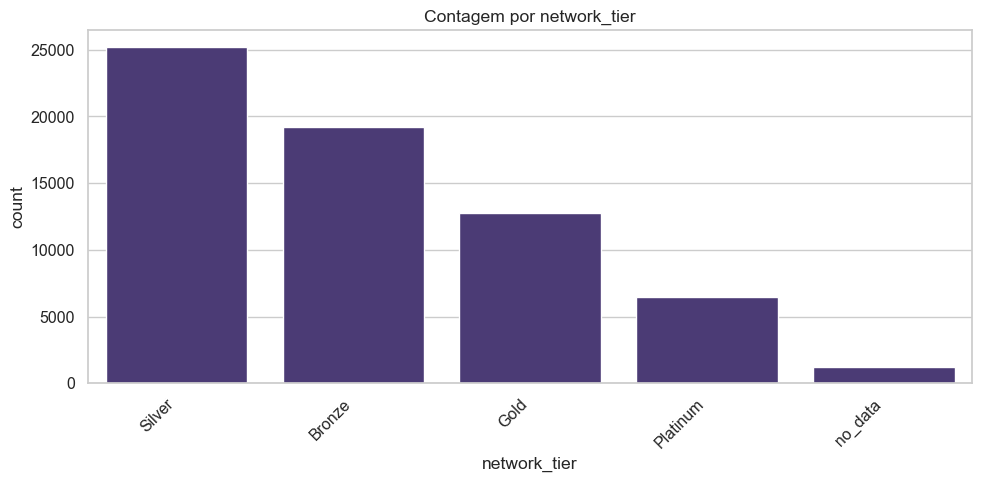

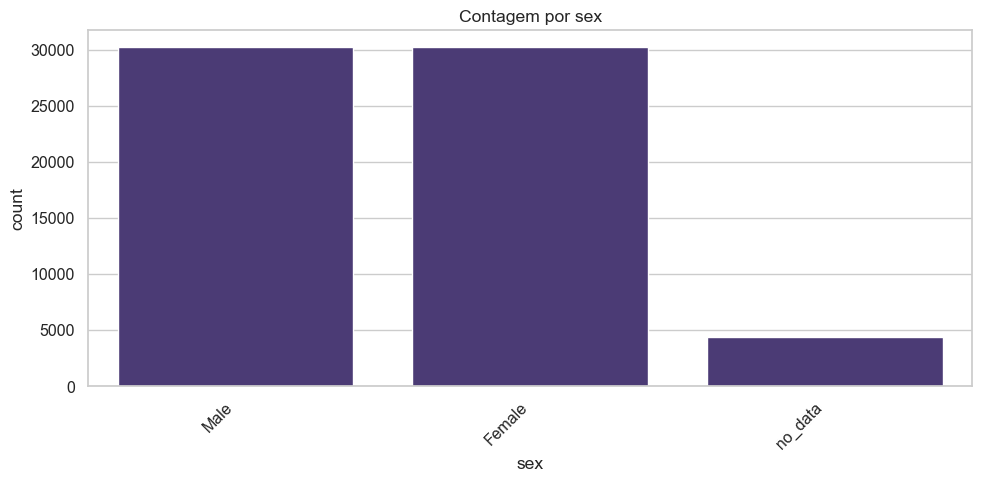

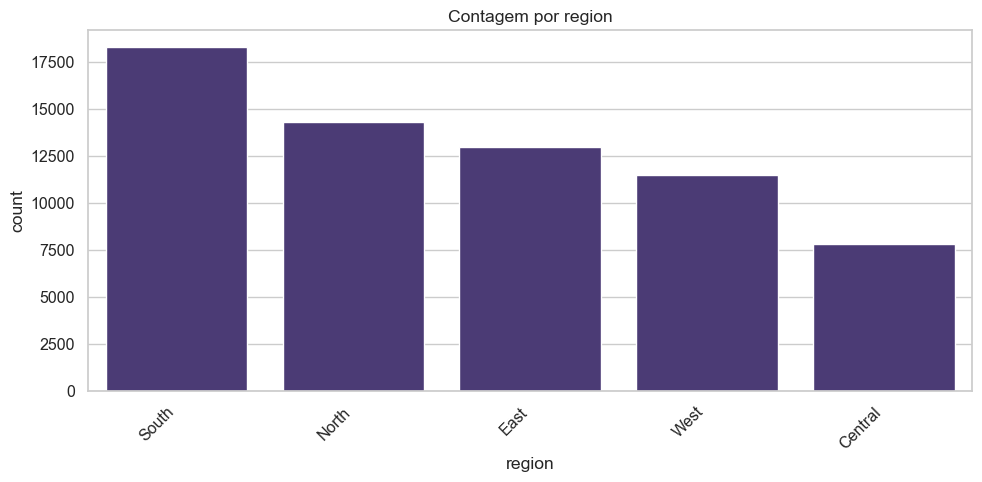

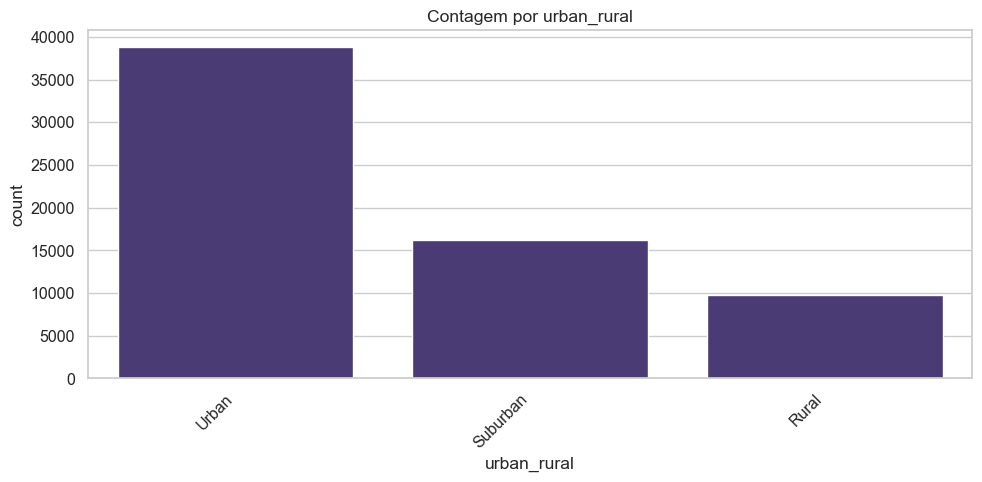

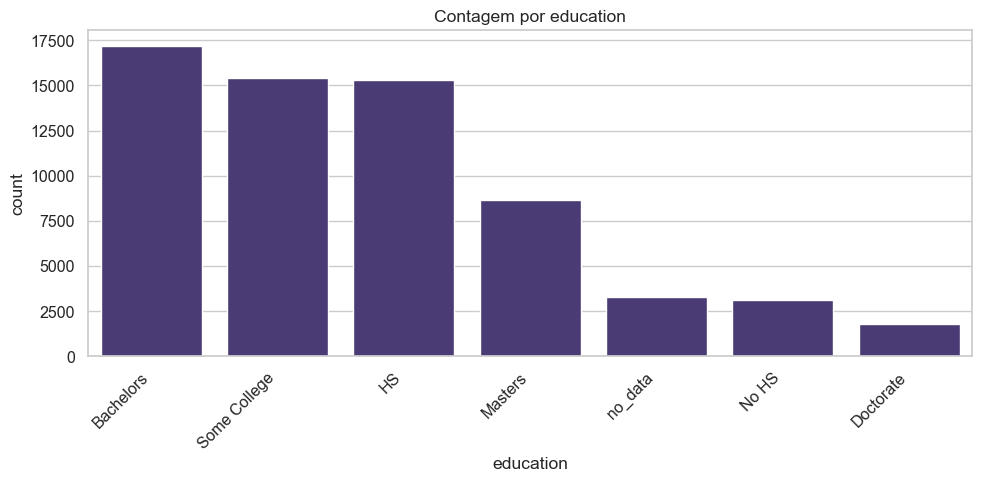

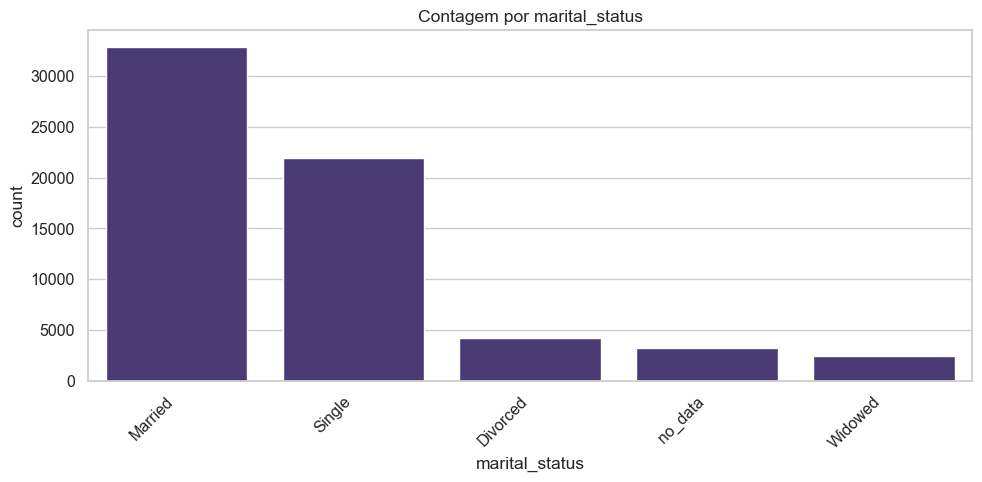

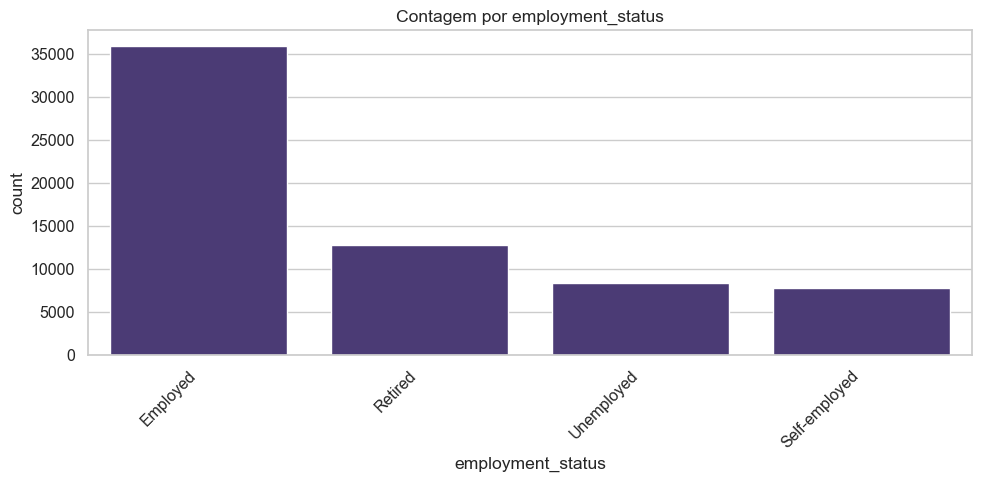

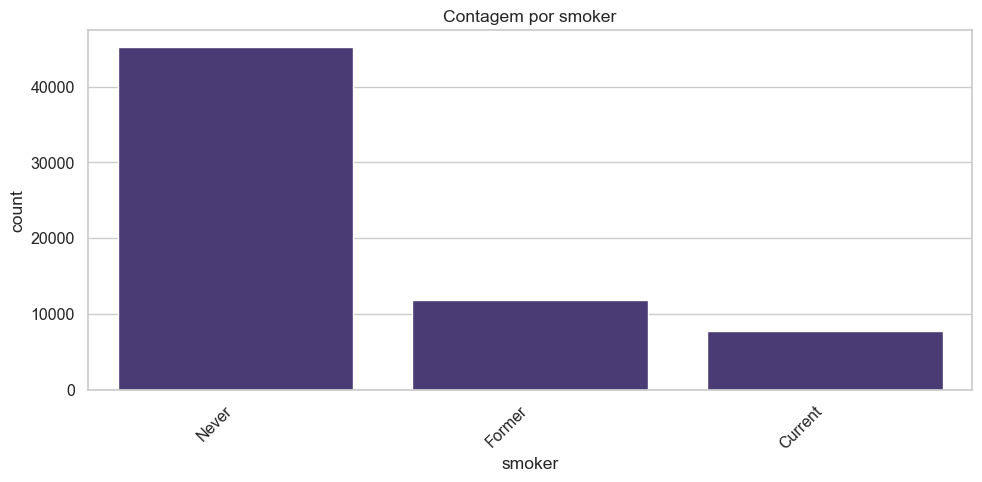

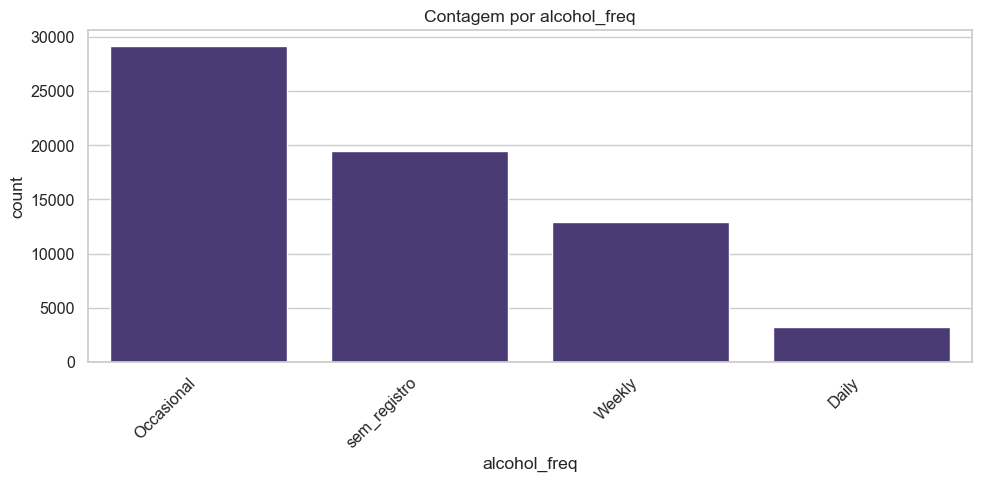

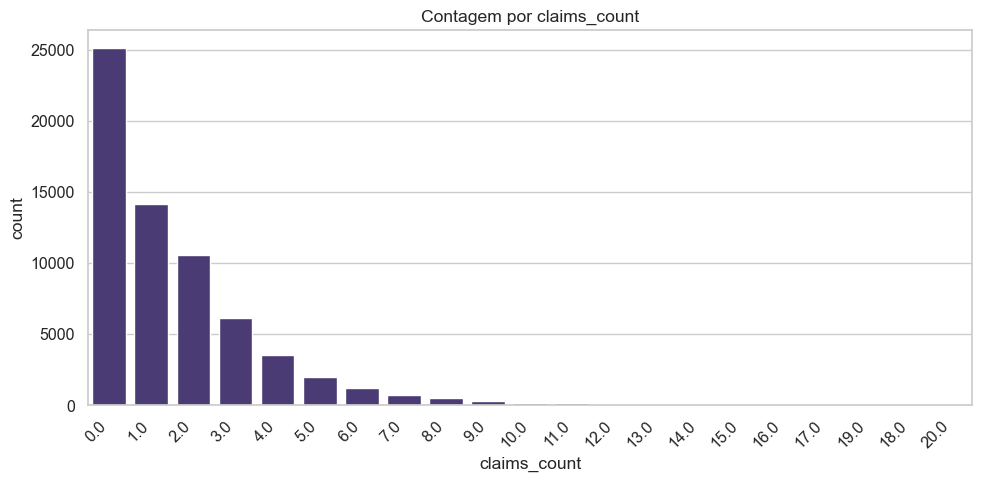

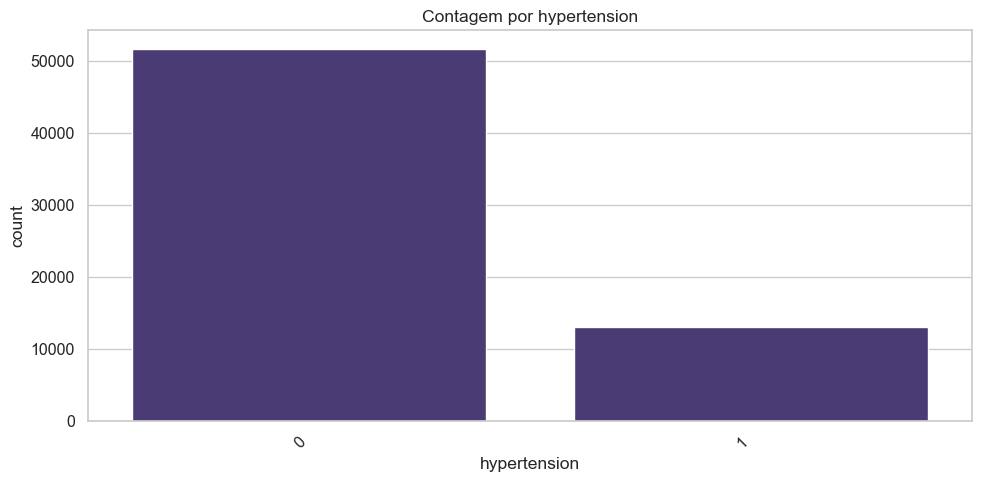

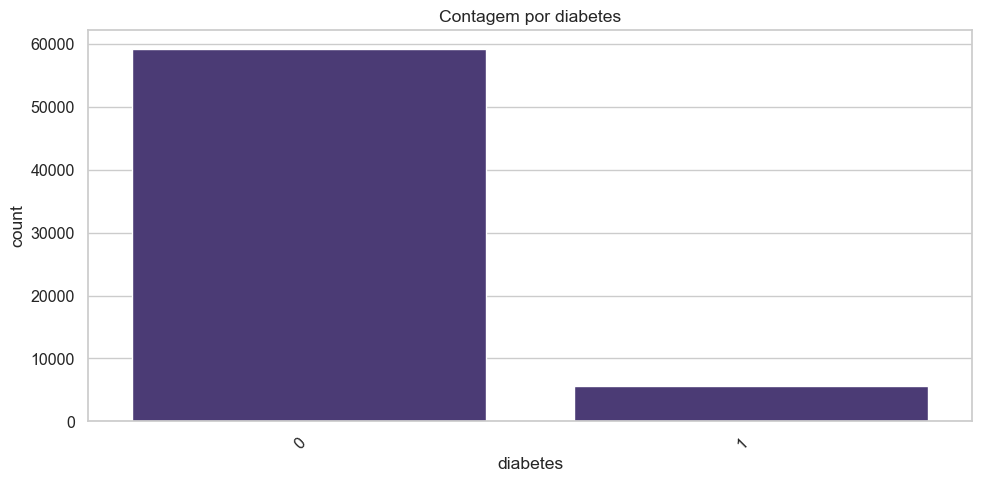

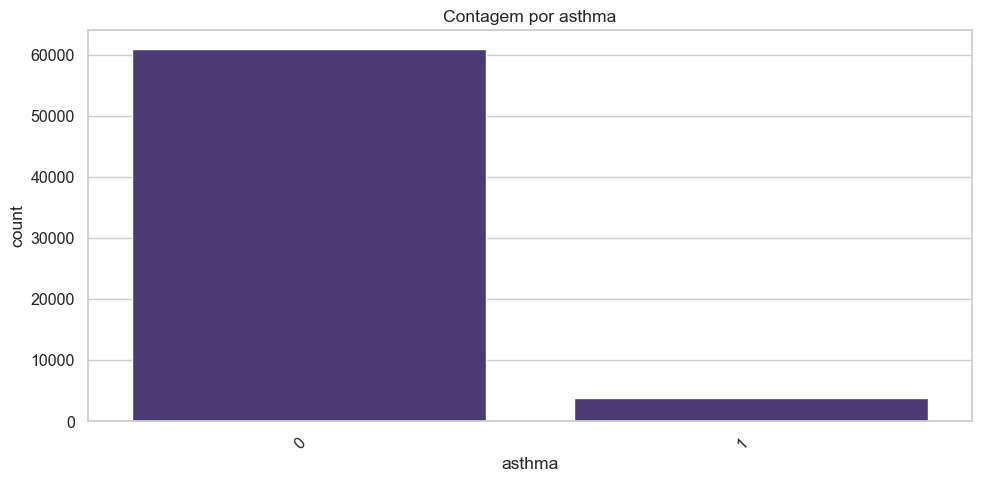

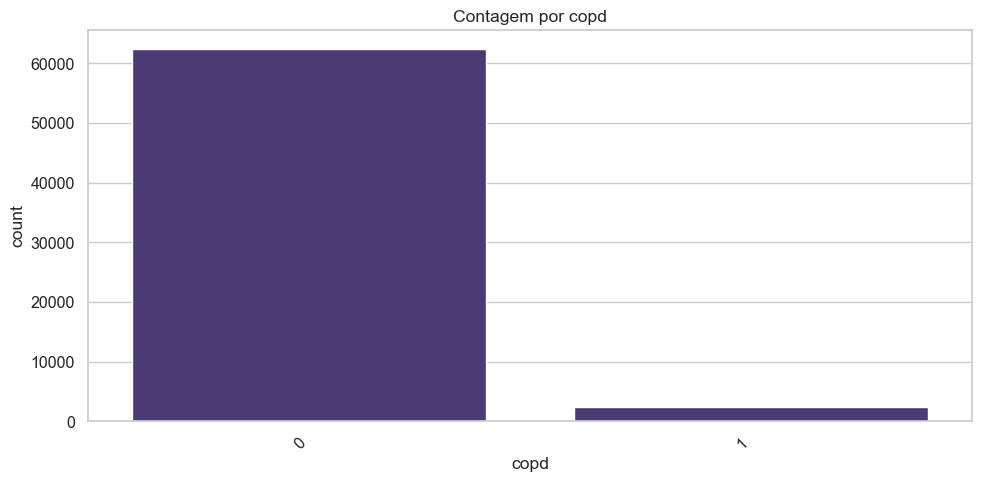

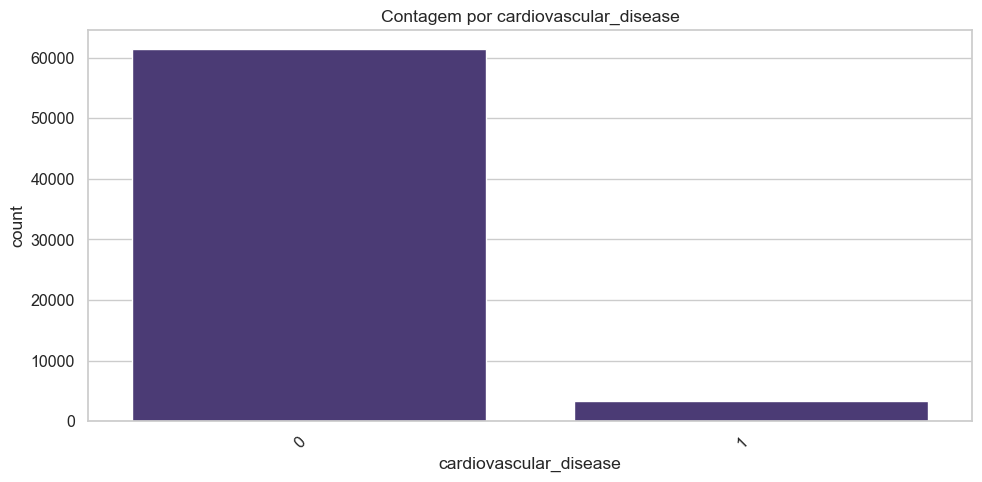

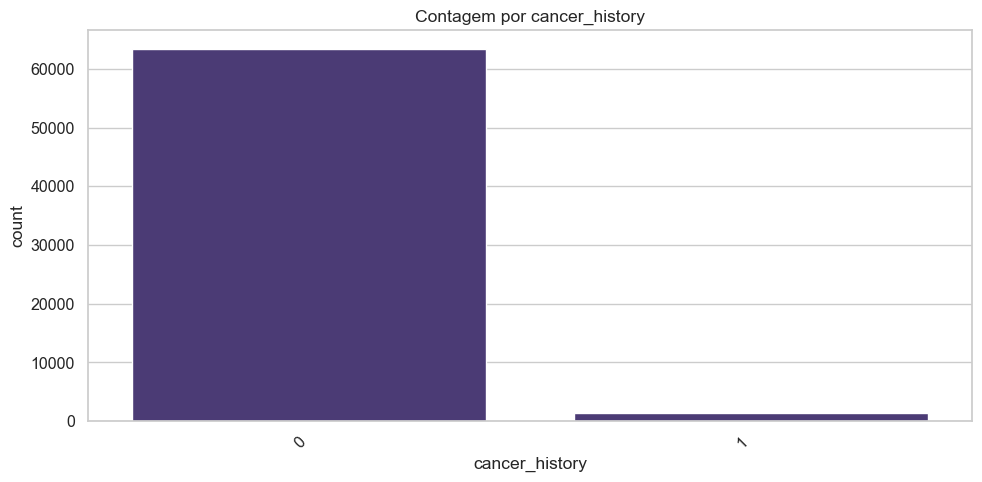

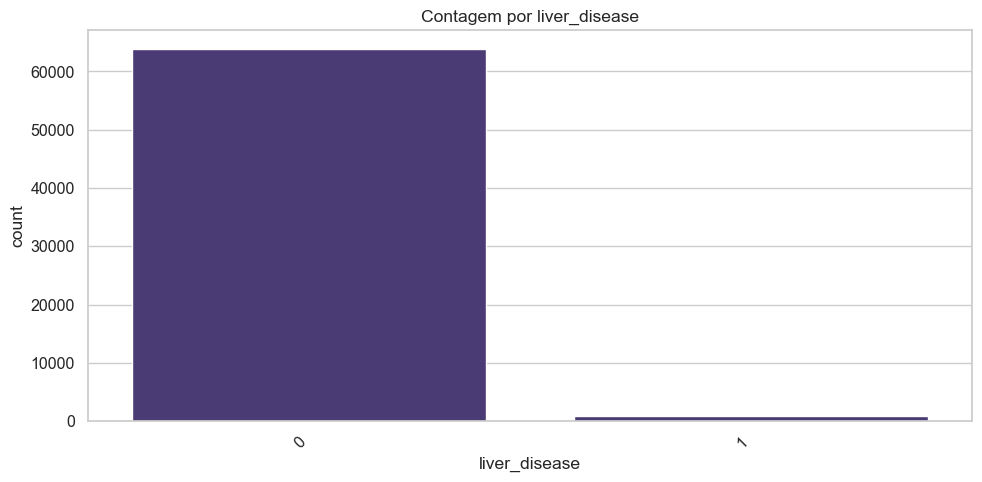

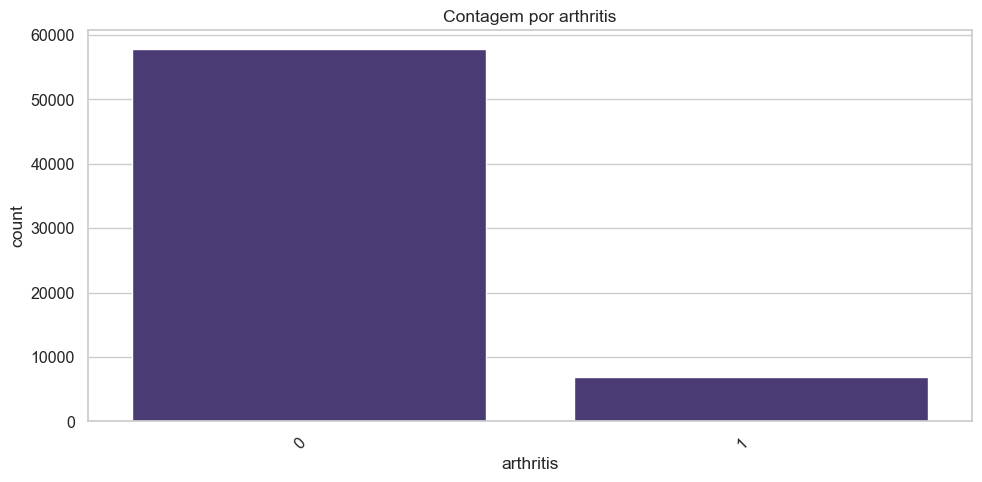

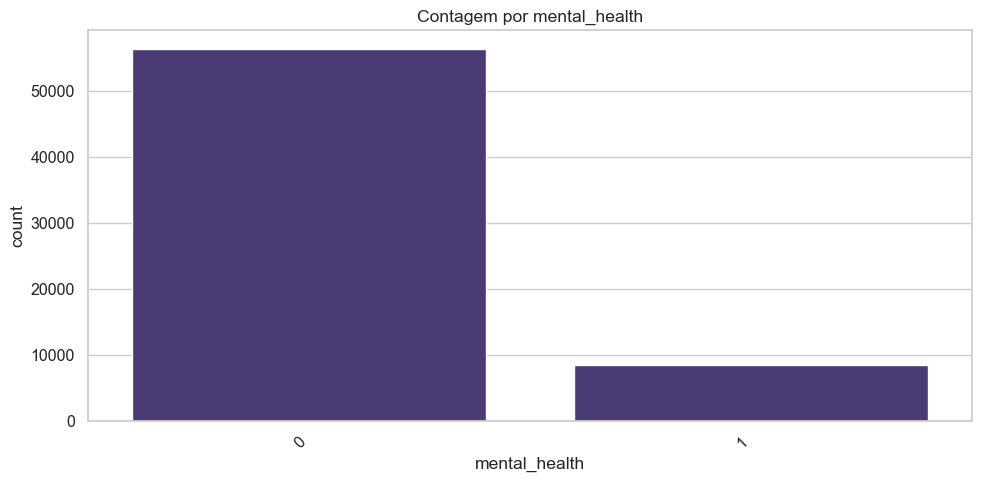

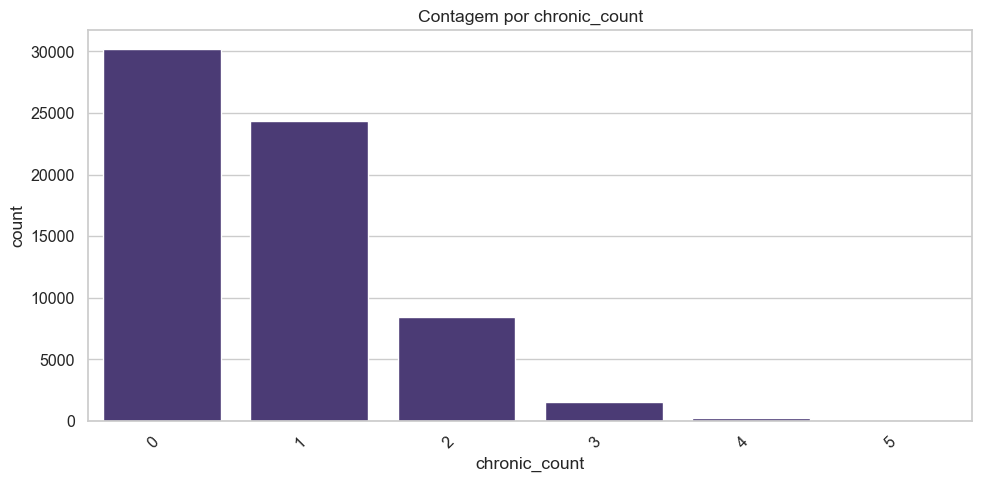

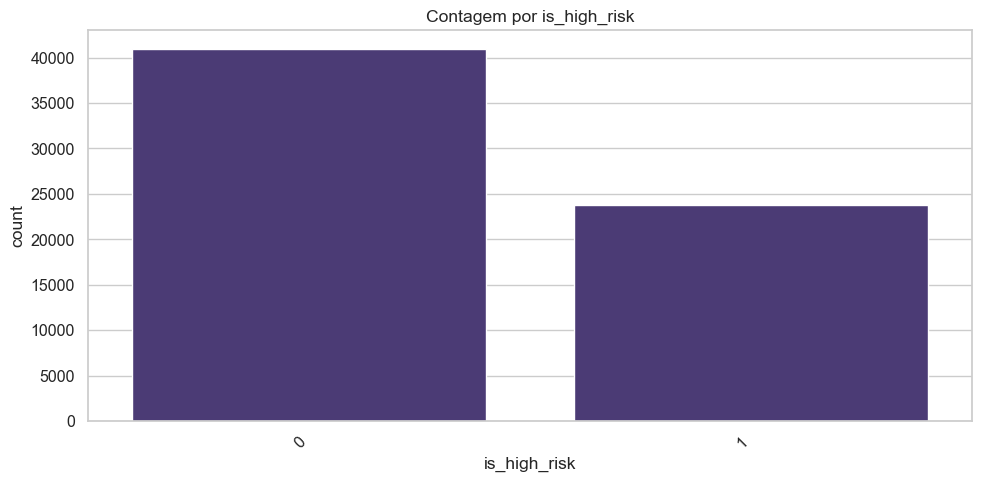

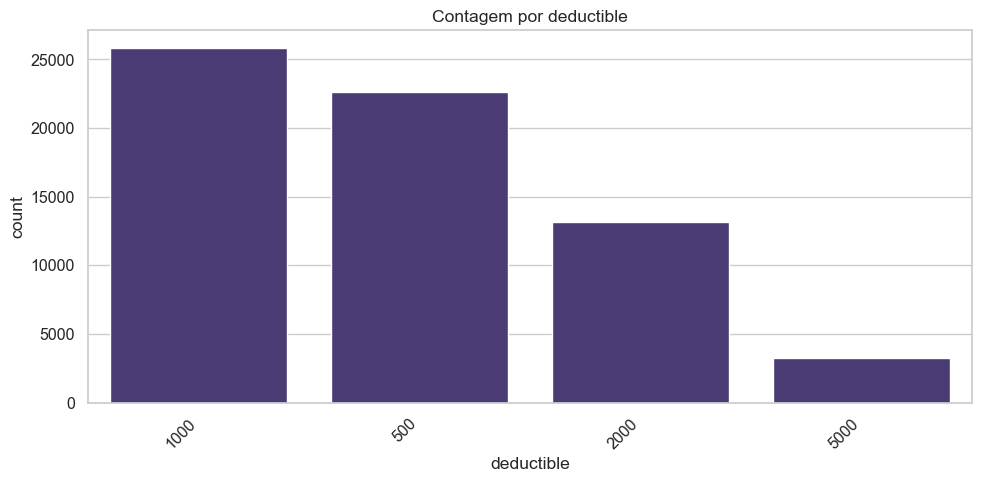

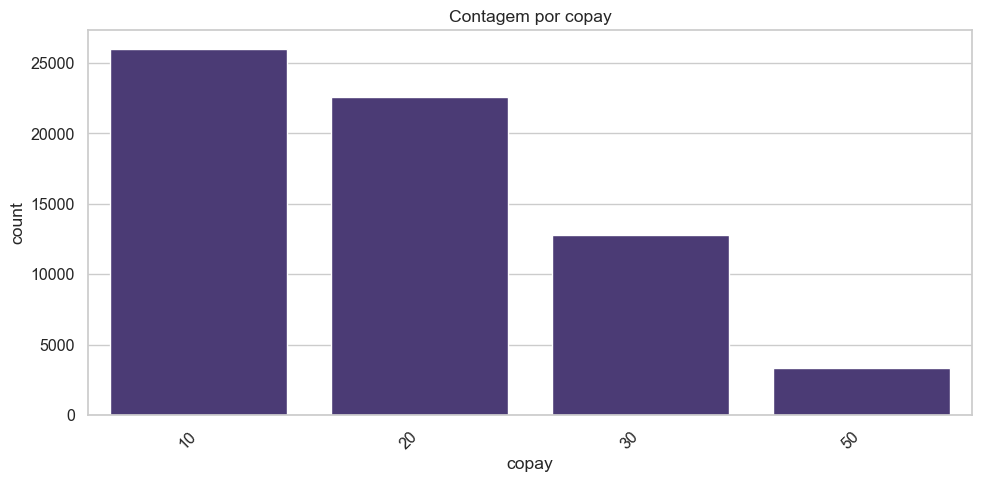

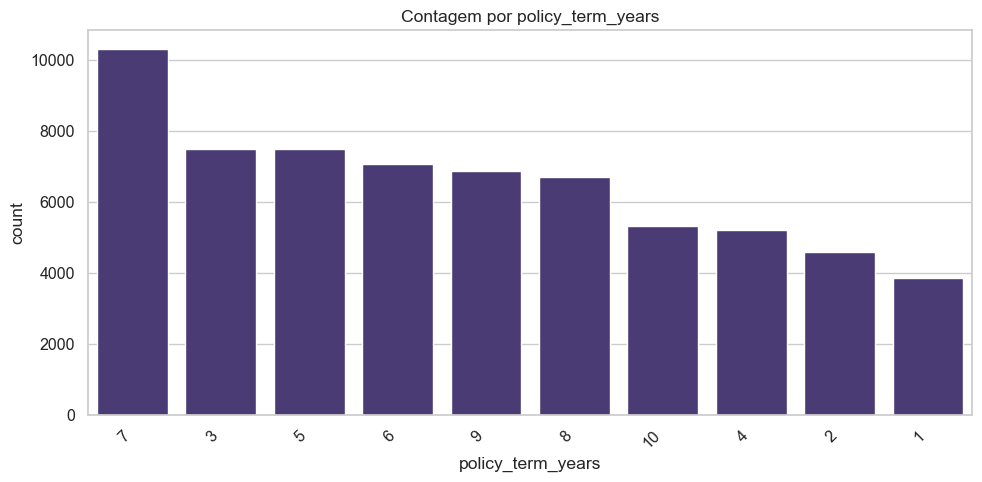

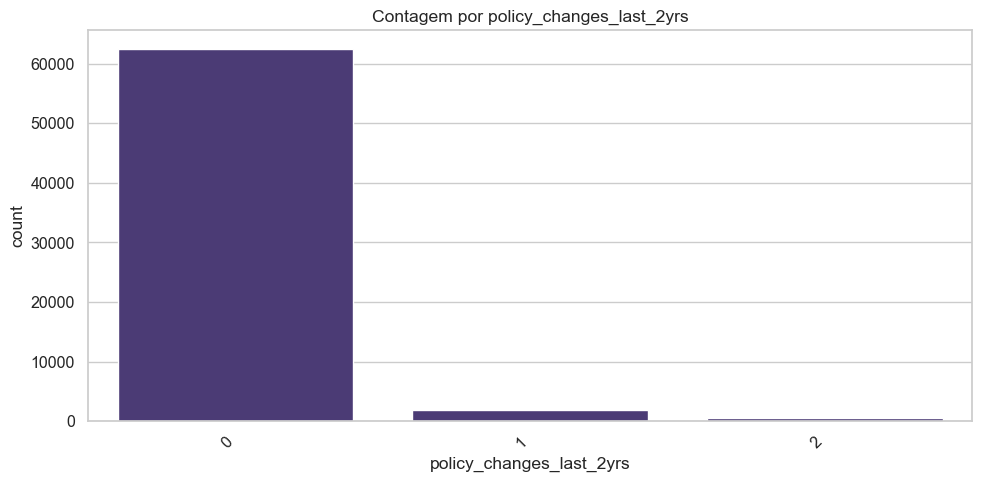

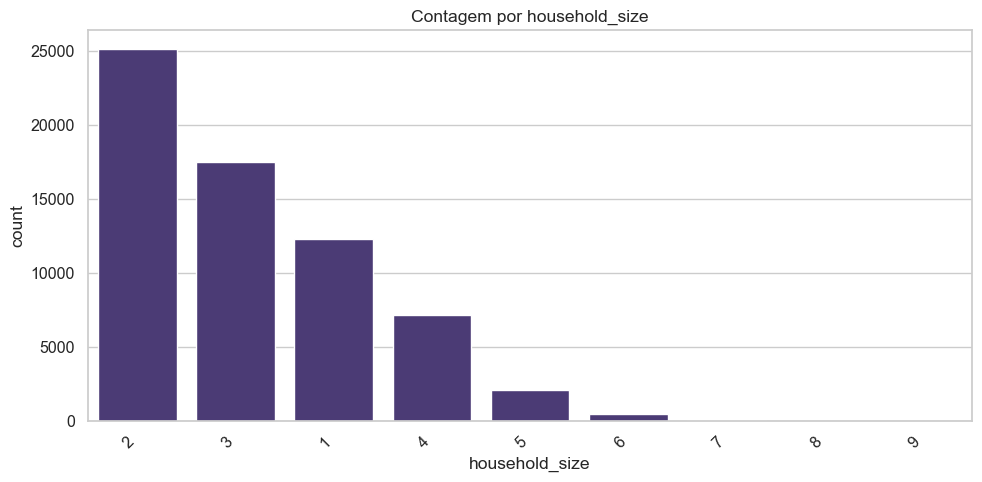

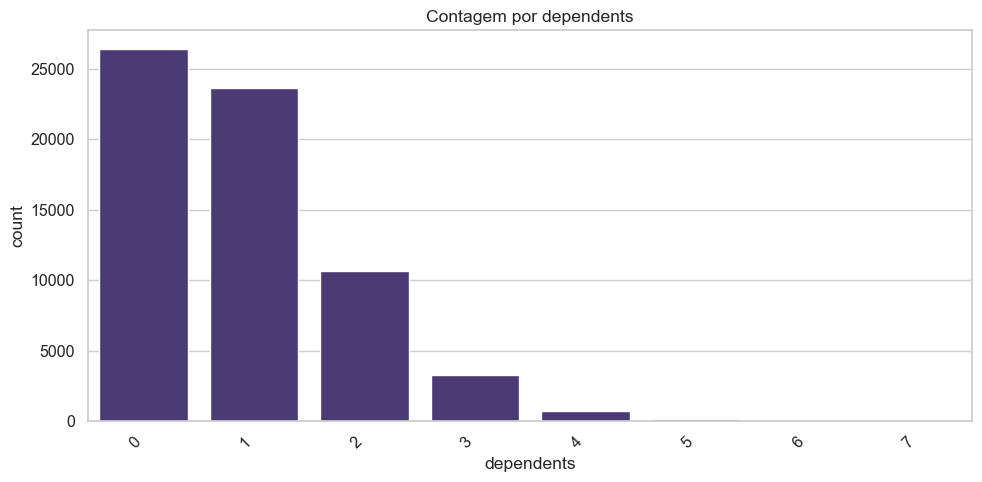

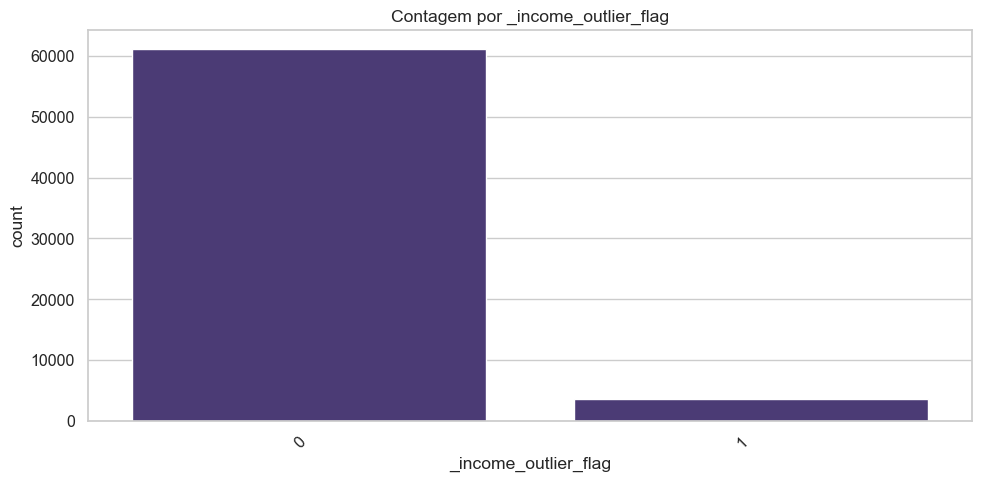

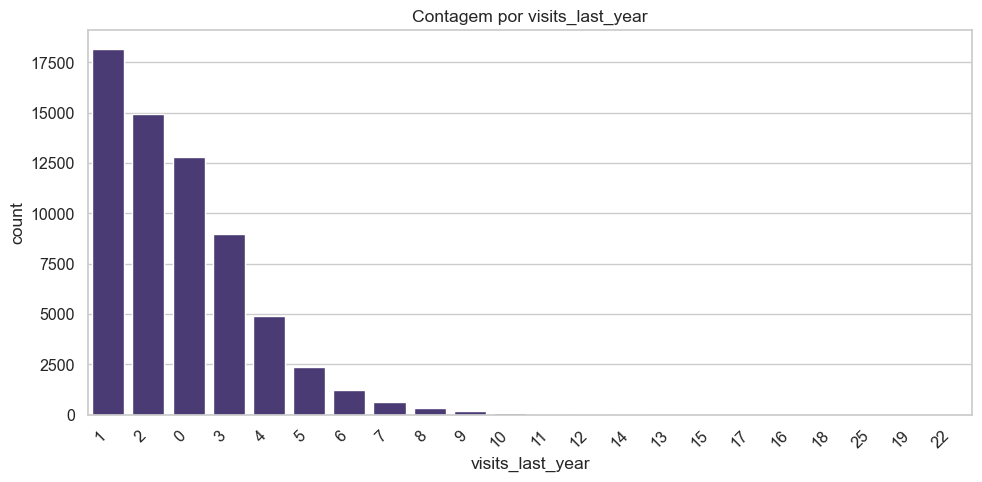

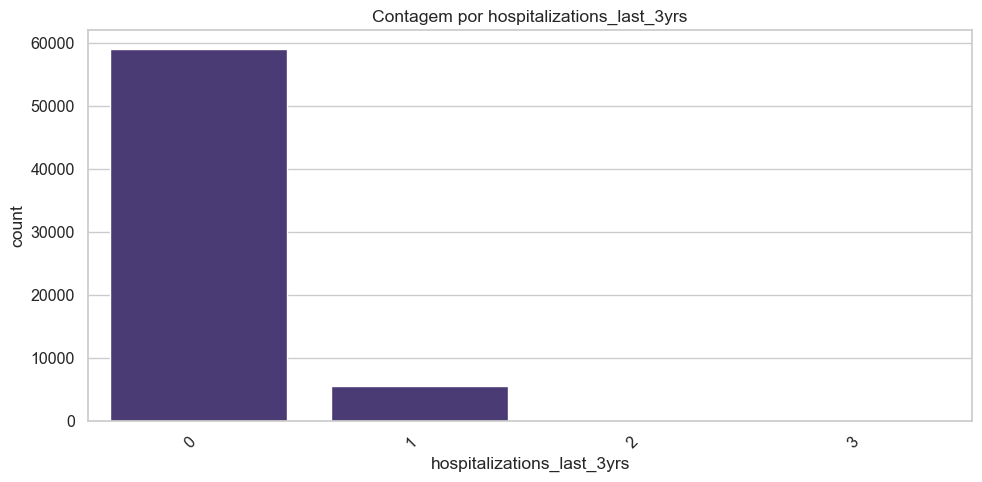

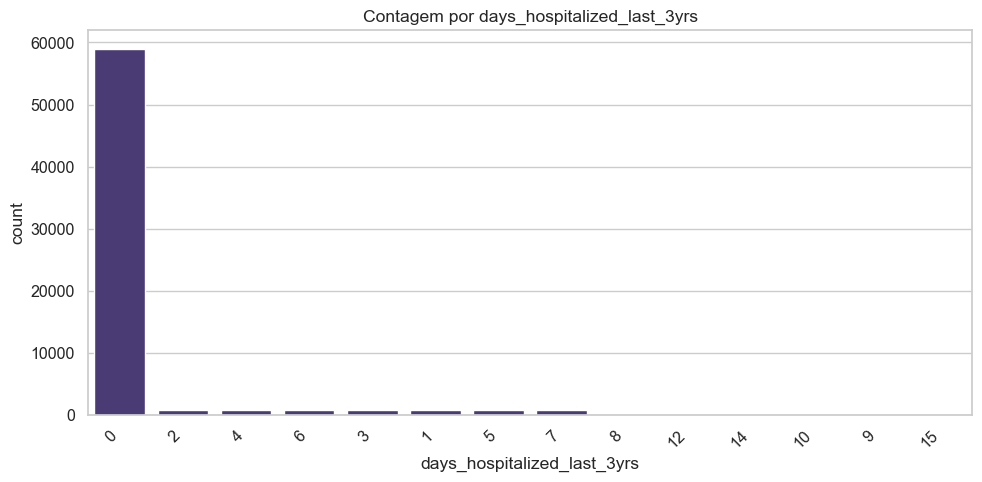

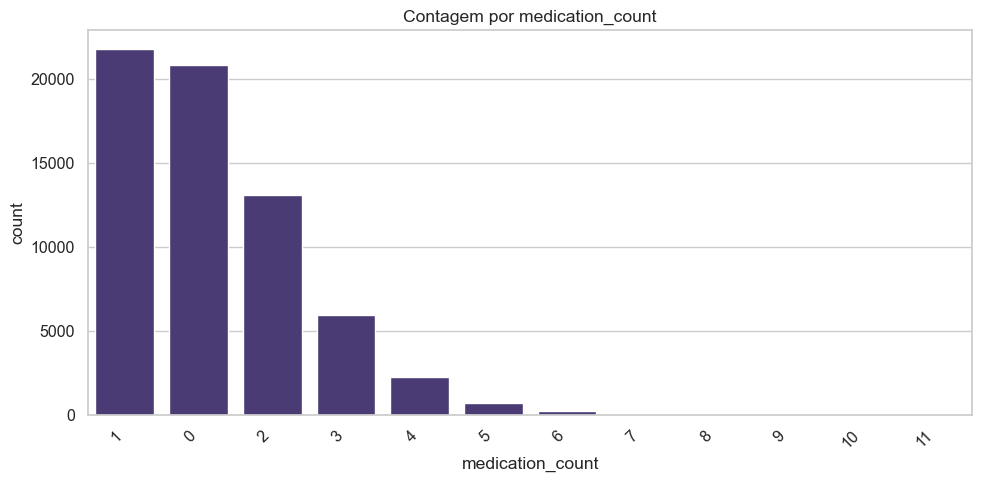

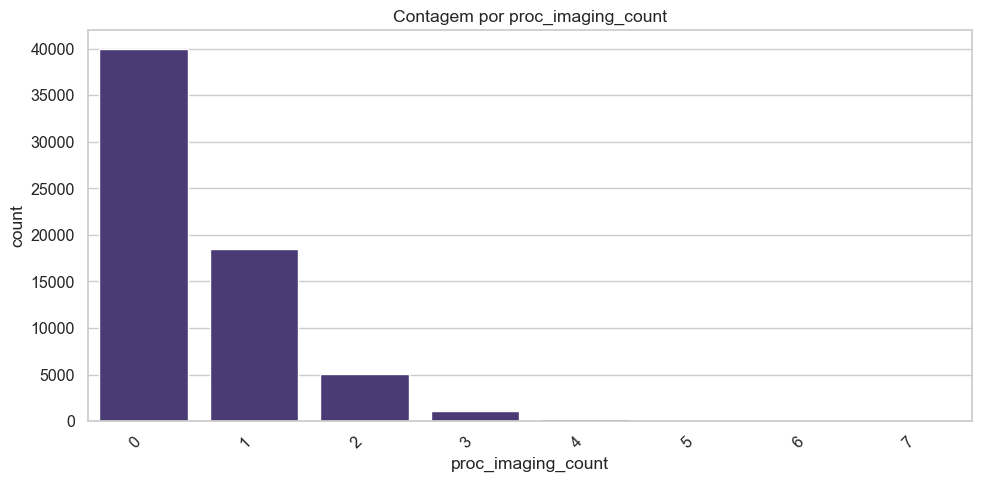

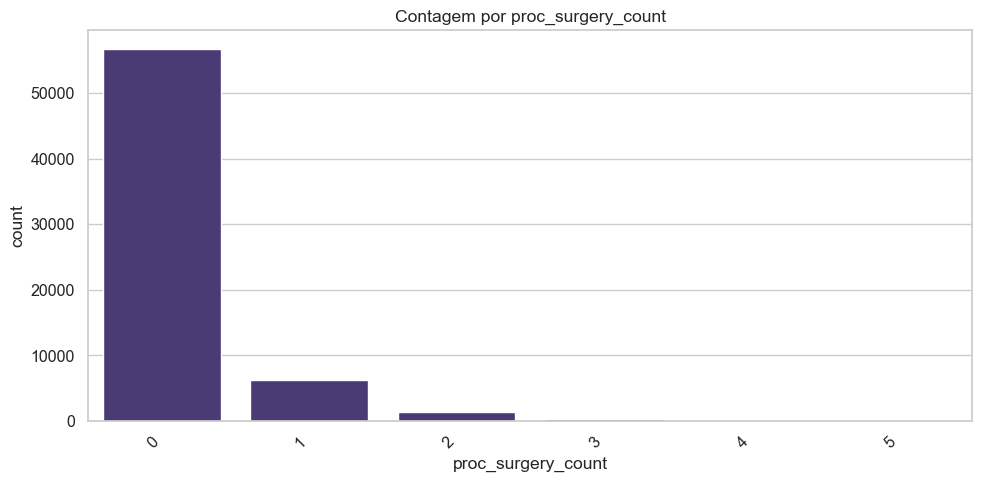

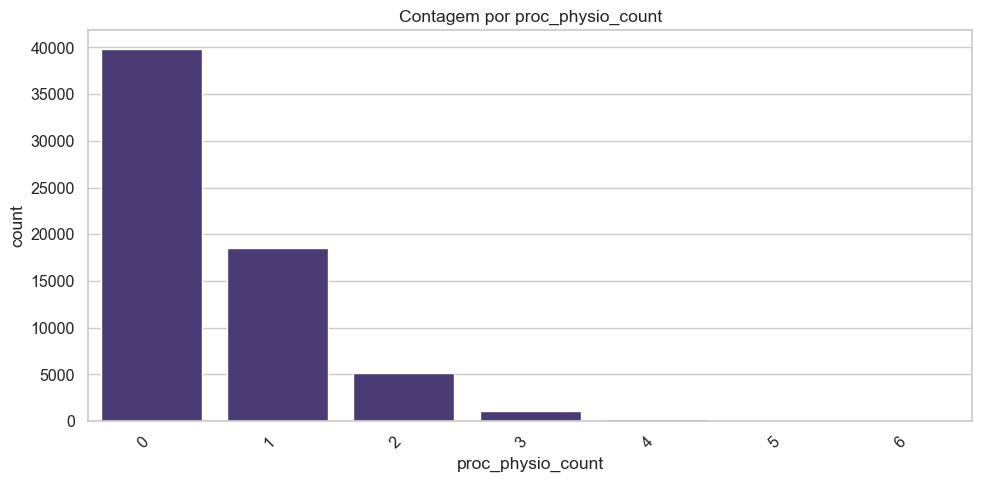

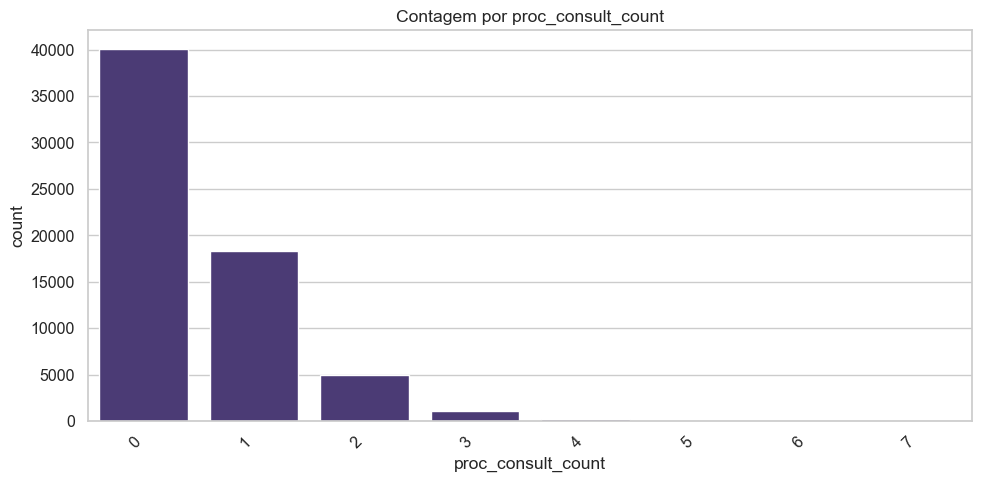

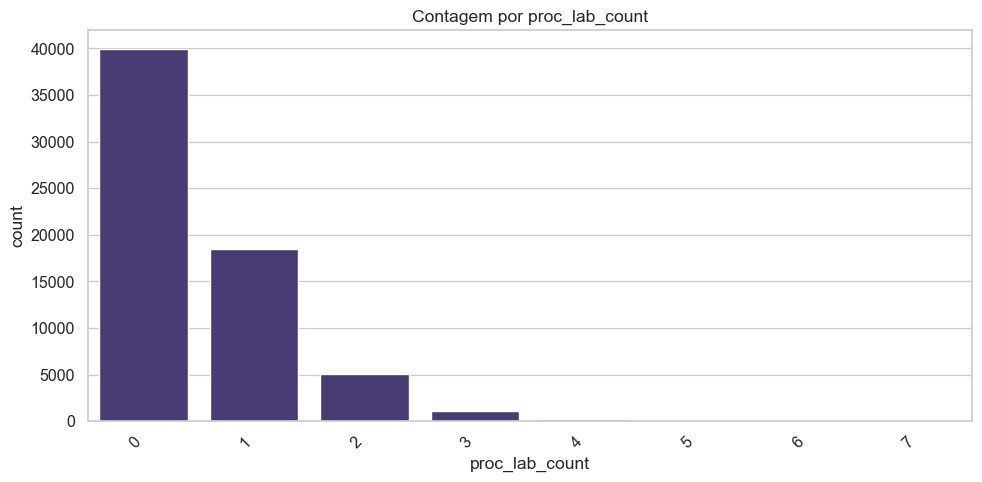

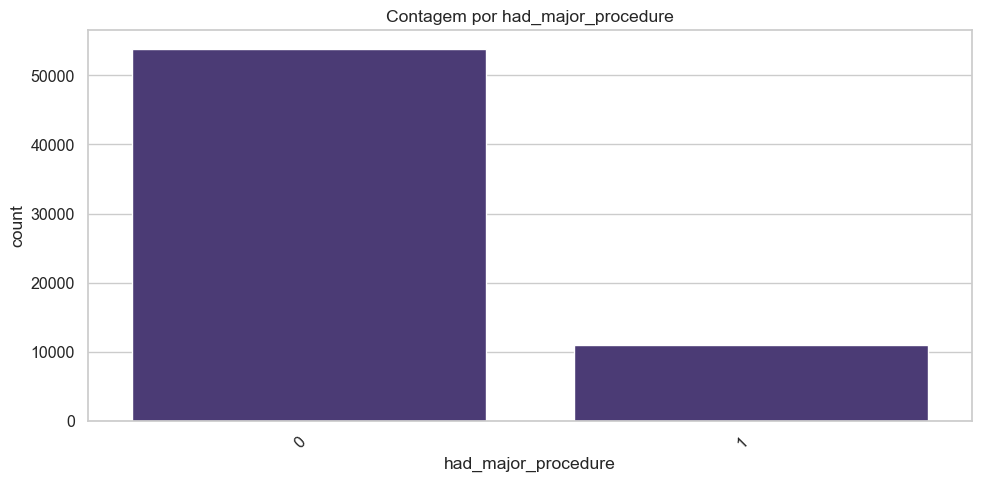

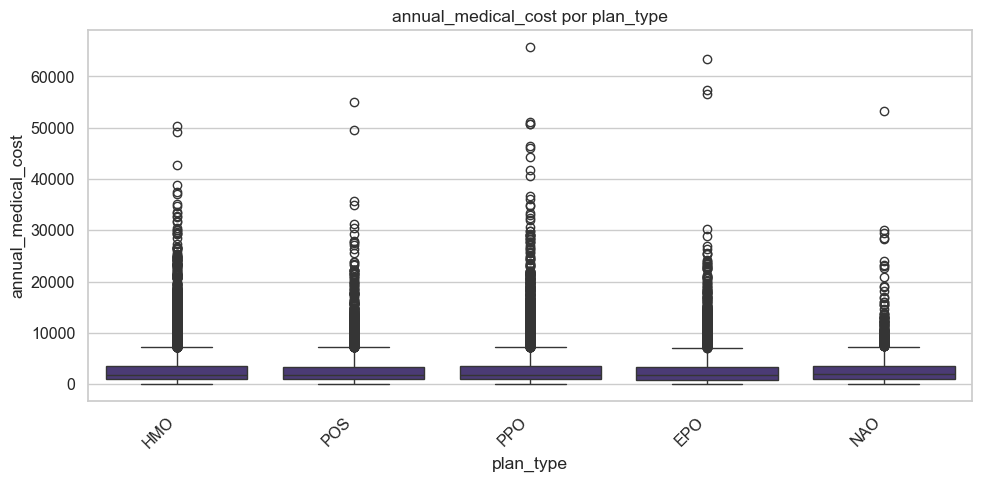

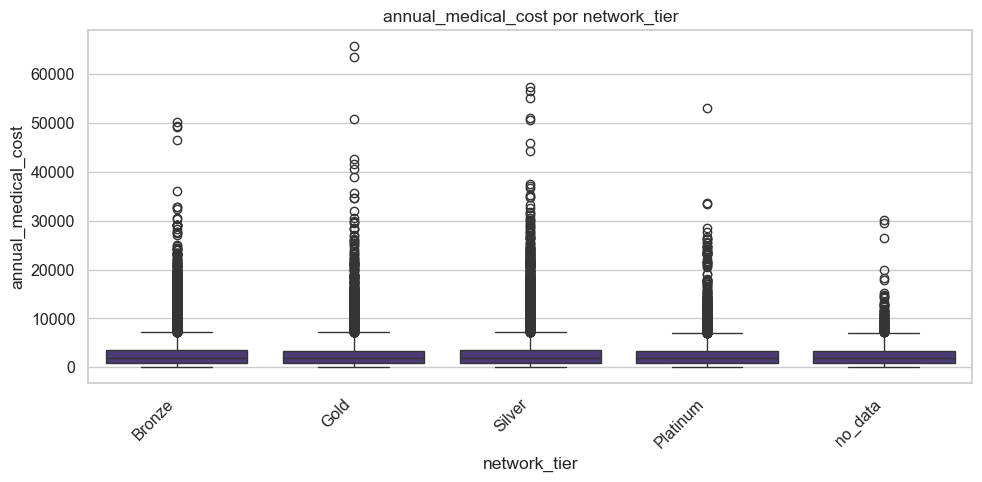

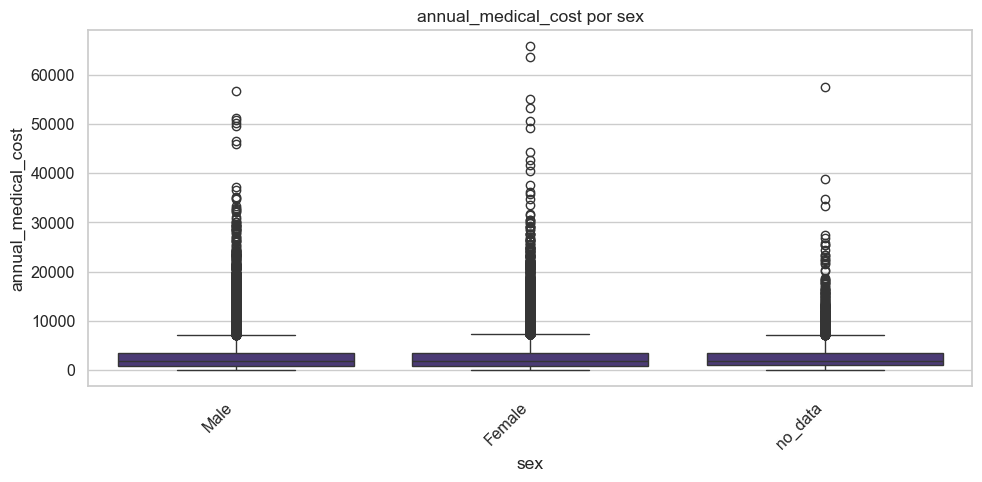

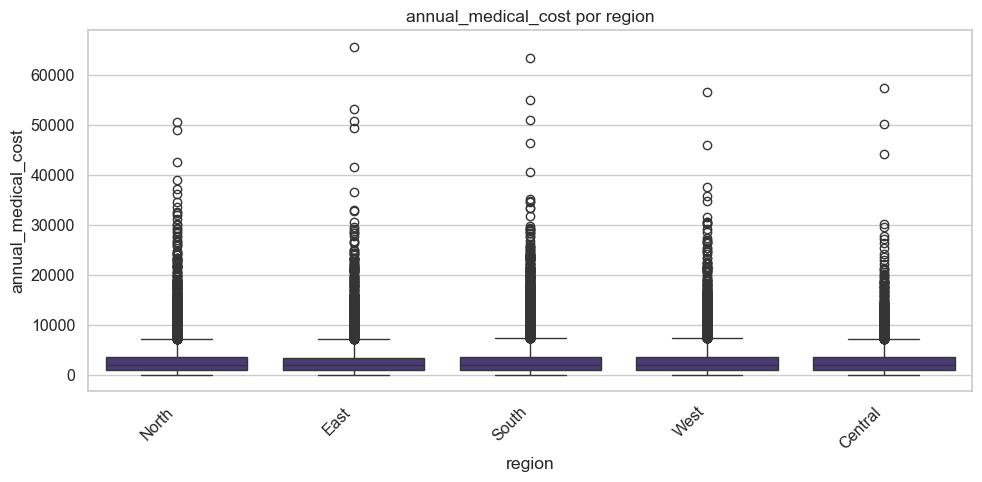

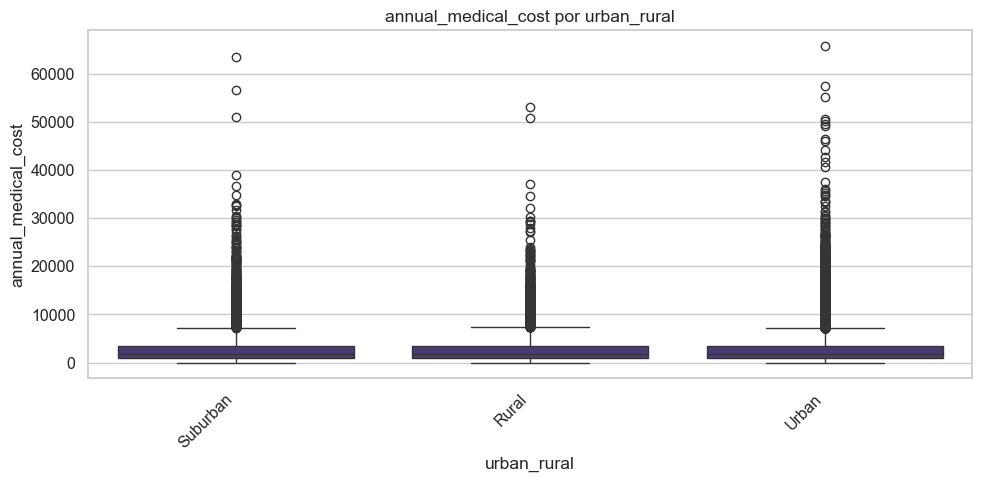

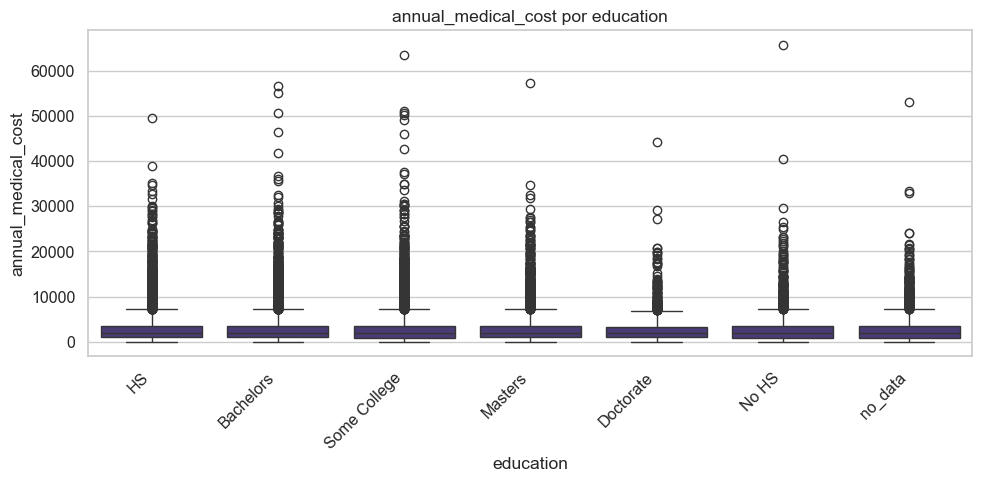

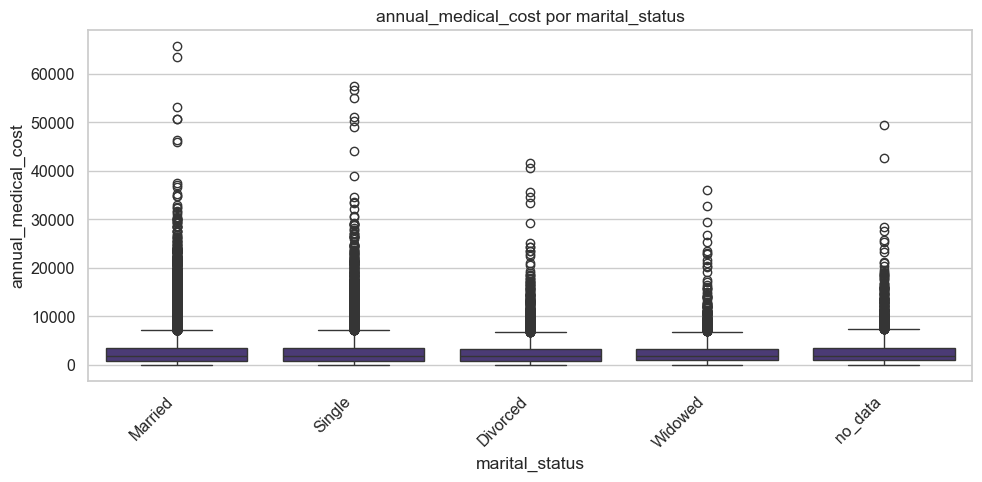

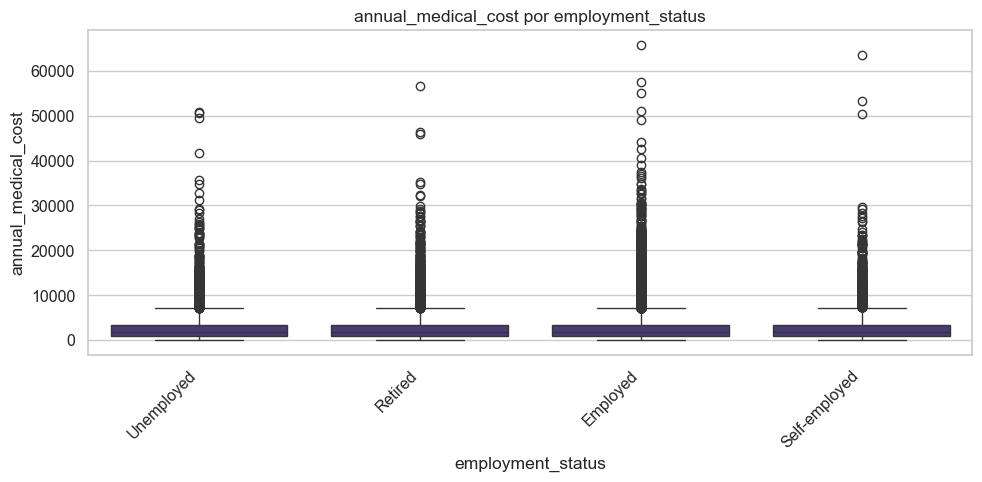

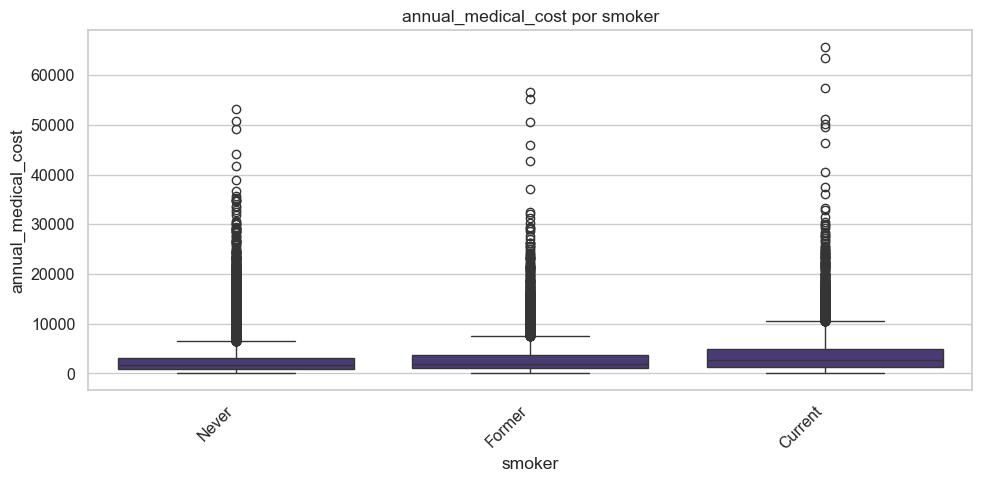

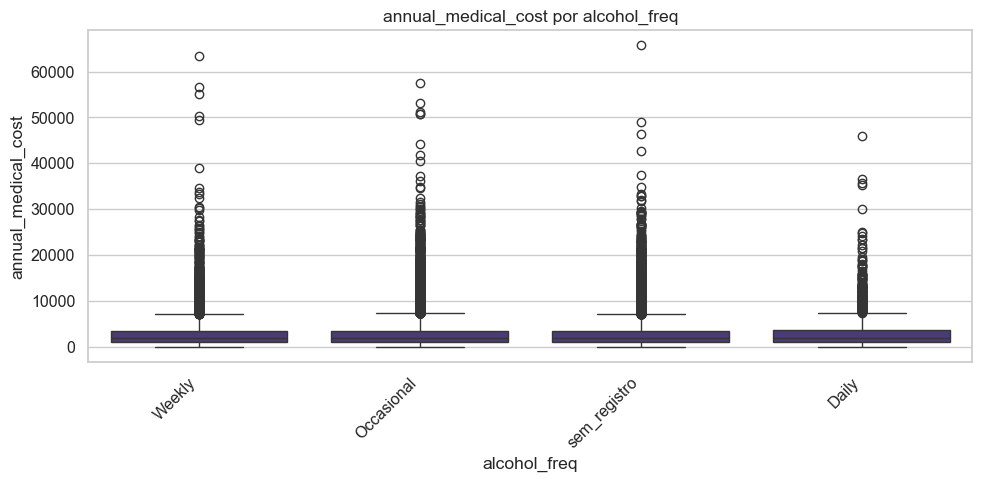

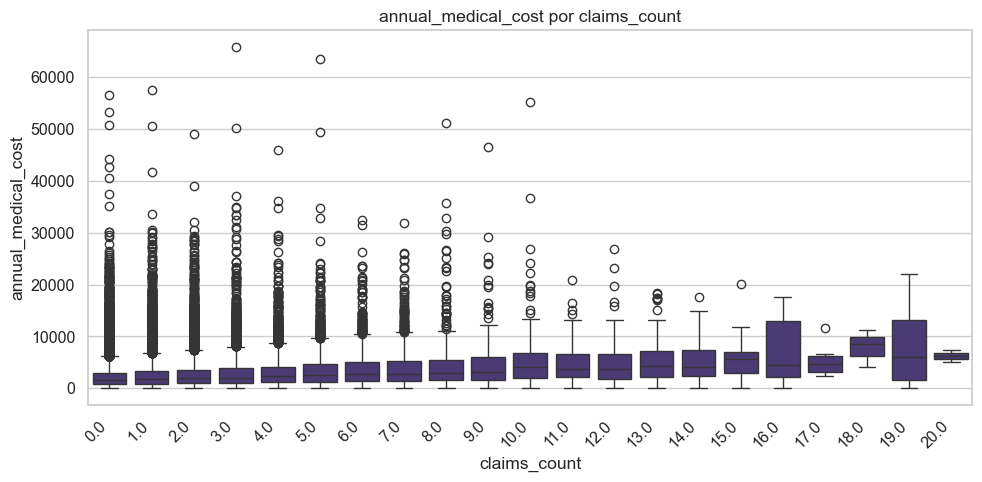

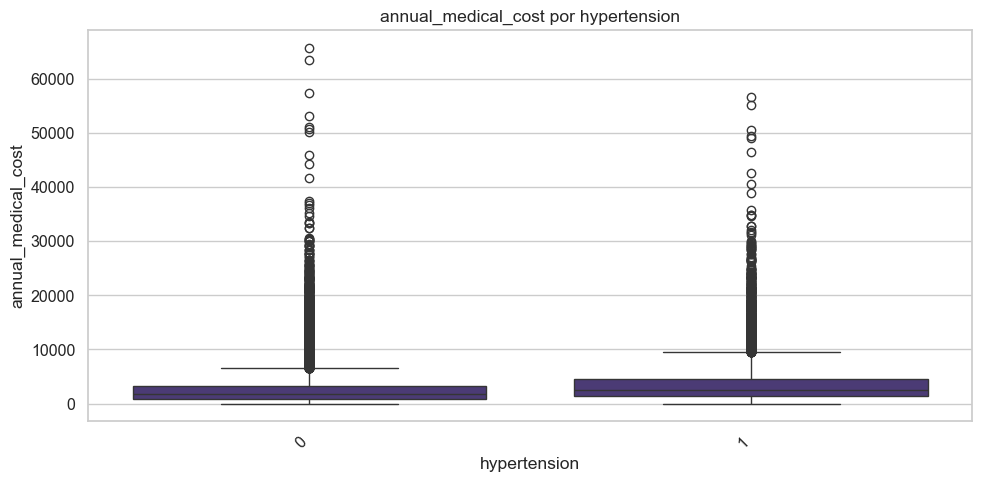

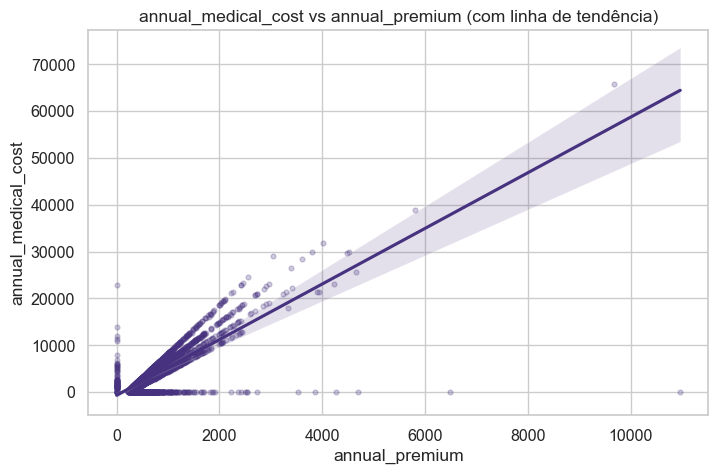

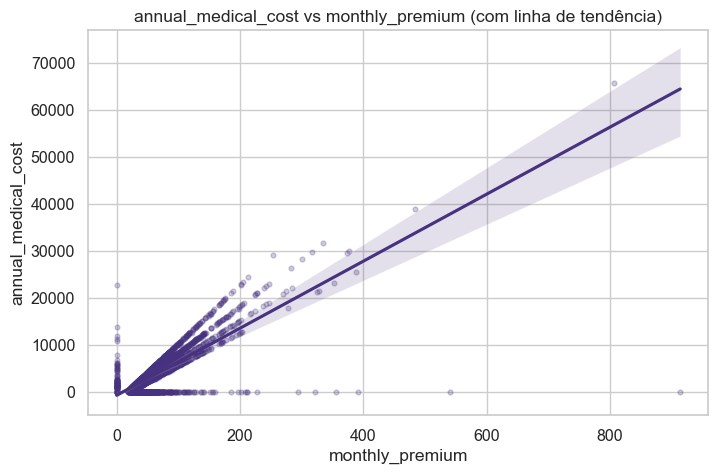

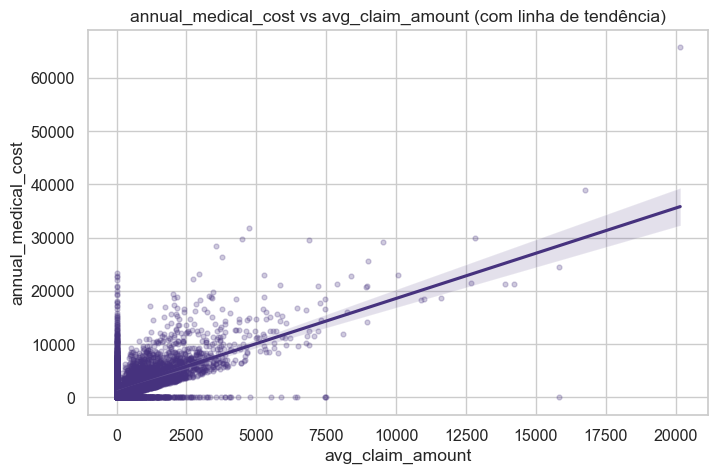

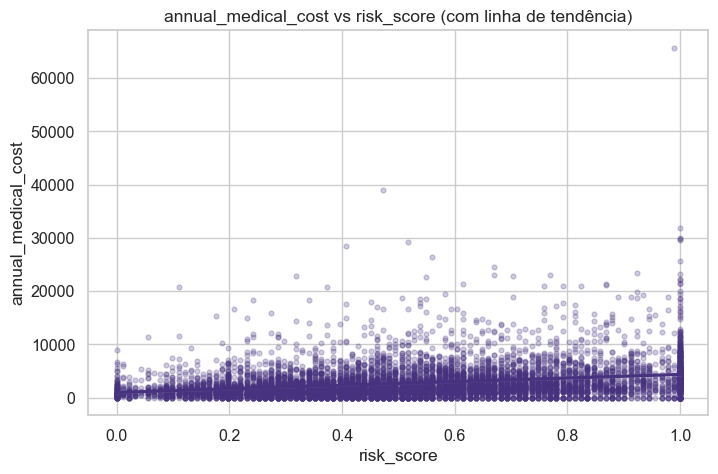

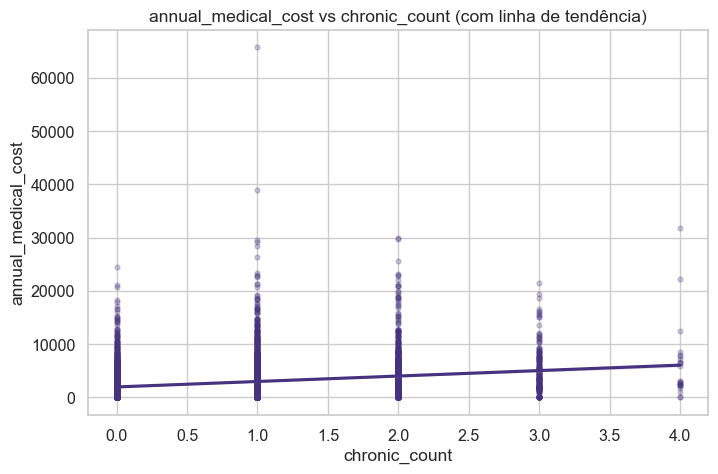

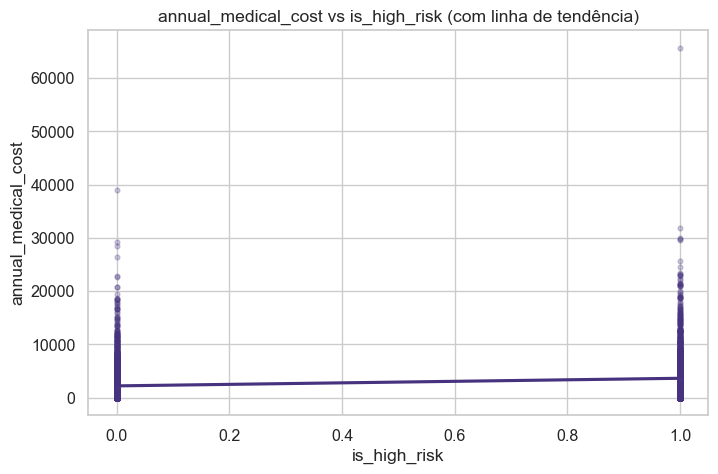

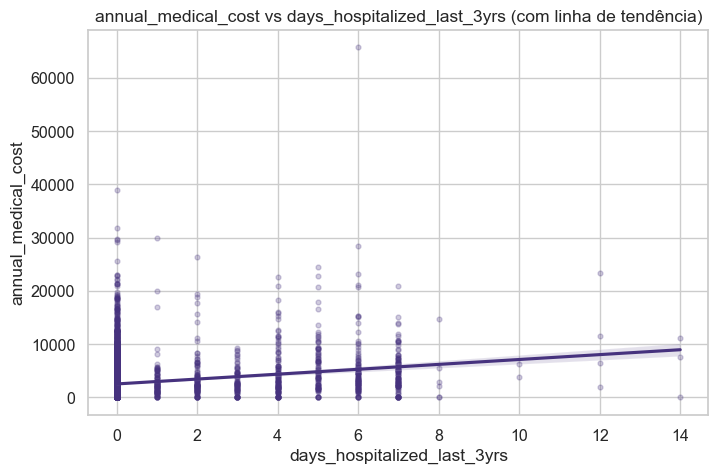

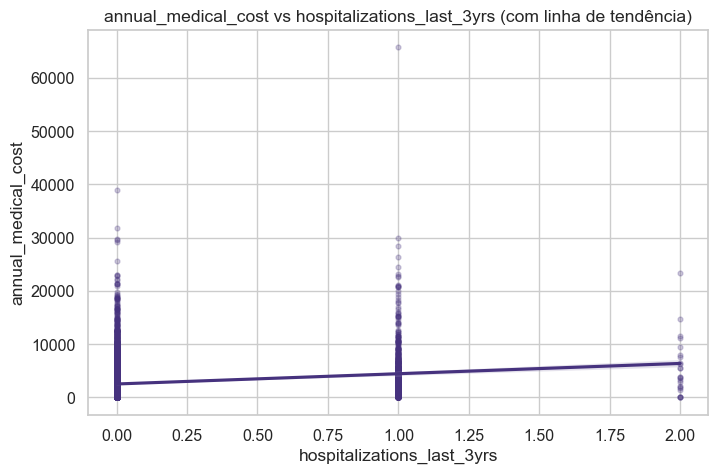

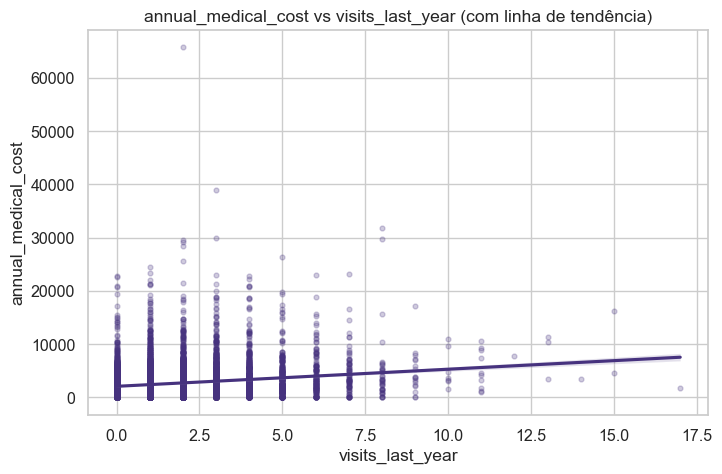

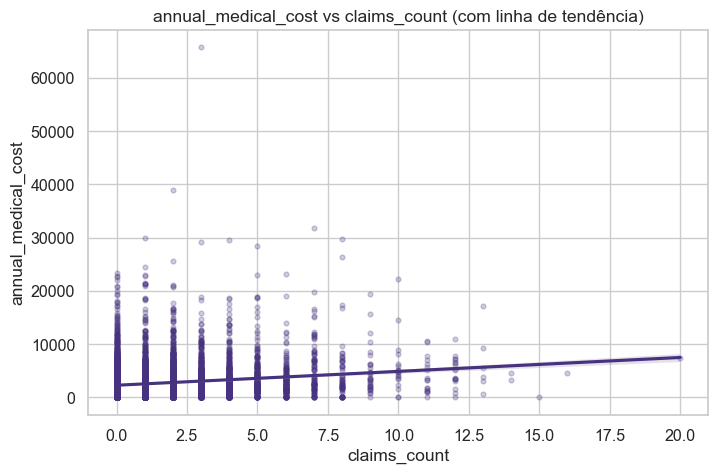

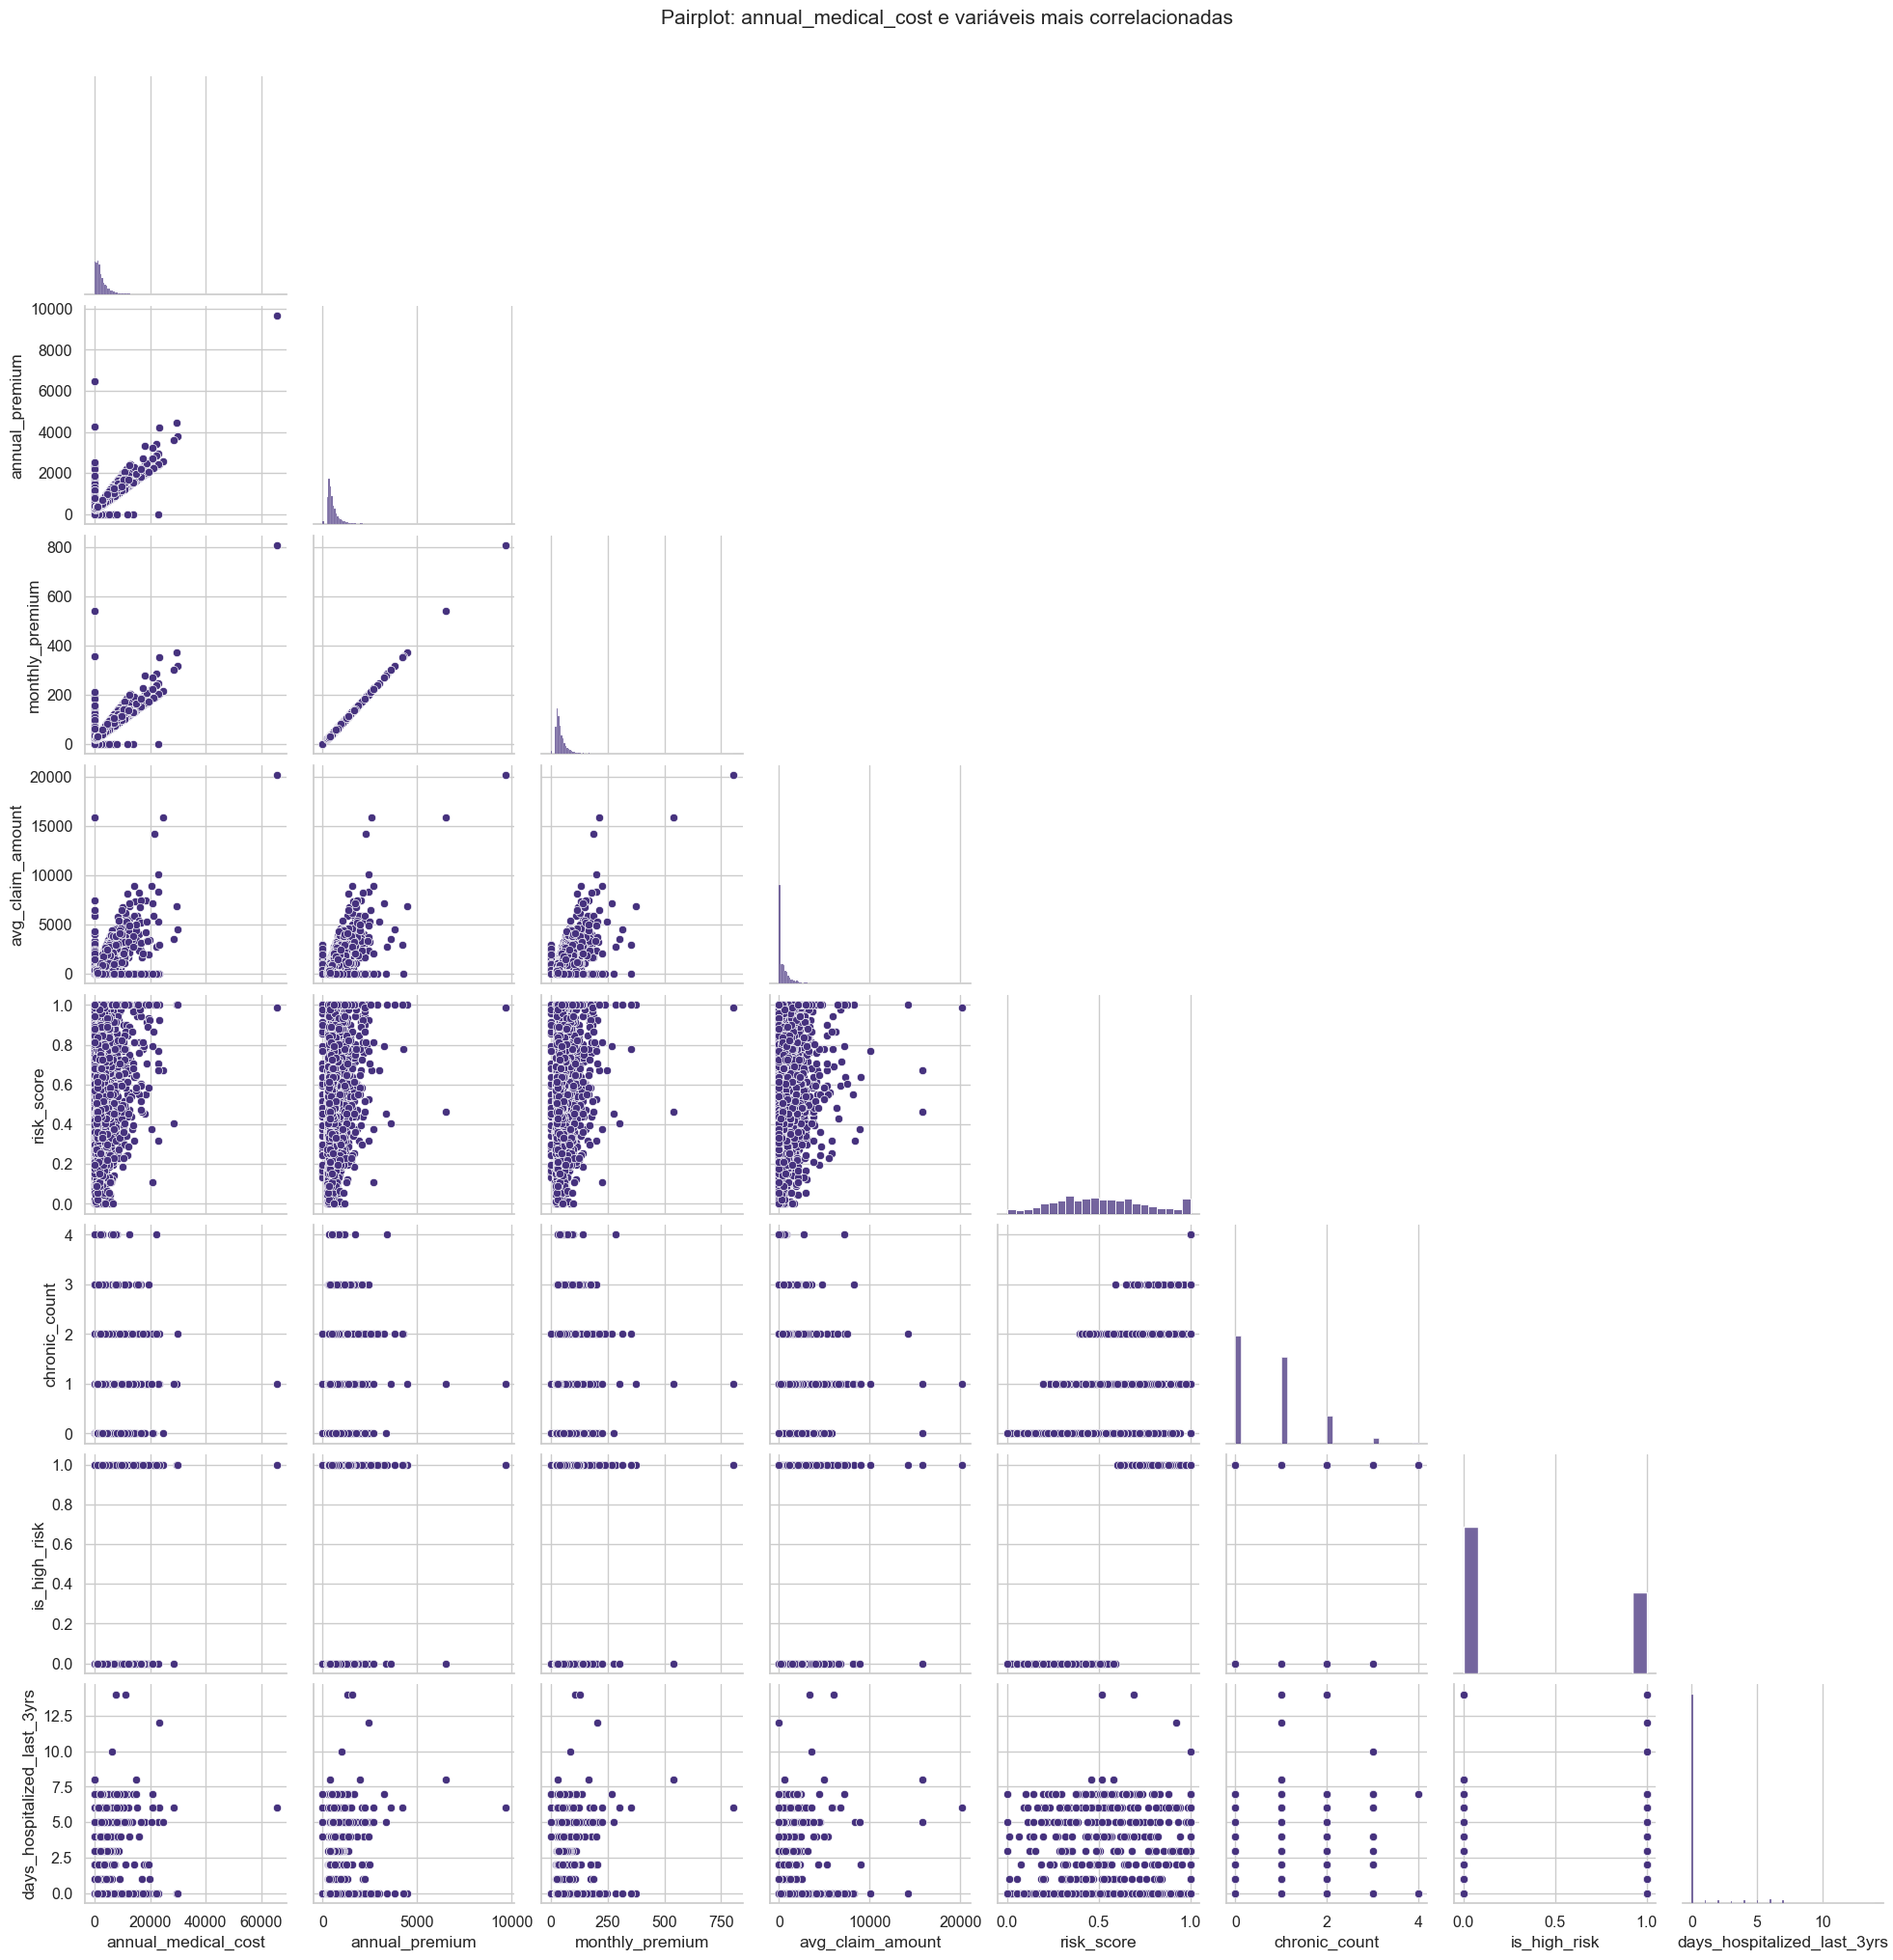


[OK] EDA concluída.


In [17]:
# ============================================
# ANÁLISE EXPLORATÓRIA AUTOMÁTICA COM SEABORN
# ============================================
# - Detecta colunas automaticamente (numéricas, categóricas, IDs)
# - Gera matriz de correlação + gráficos essenciais de EDA
# - Minimiza necessidade de editar nomes de colunas
#
# Requisitos:
#   pip install pandas seaborn matplotlib numpy
# ============================================

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# -----------------------------
# CONFIGURAÇÕES GERAIS
# -----------------------------
CSV_PATH = Path("/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv")
# Alternativa (caso rode aqui no notebook com o arquivo enviado):
# CSV_PATH = Path("/mnt/data/full_warehouse_merged.csv")

TARGET_CANDIDATES = ["annual_medical_cost", "annual_premium", "monthly_premium"]  # ordem de preferência
MAX_PAIRPLOT_VARS = 8       # Nº máx de variáveis no pairplot (alvo + top features)
MAX_SCATTERS = 10           # Nº máx de scatters (top numéricas x alvo)
MAX_BOXPLOTS = 12           # Nº máx de boxplots (top categóricas x alvo)
LOW_CARDINALITY_MAX = 30    # Limite p/ considerar uma numérica como "quase categórica"
SAMPLE_FOR_SCATTER = 8000   # Amostra p/ não pesar scatter/regplot
SAVE_FIGS = False           # Se True, salva PNGs em ./figs
FIG_DPI = 110

# -----------------------------
# FUNÇÕES AUXILIARES
# -----------------------------
def tight_title(title, width=80):
    return "\n".join(textwrap.wrap(title, width=width))

def ensure_figdir():
    out = Path("figs")
    out.mkdir(exist_ok=True)
    return out

def savefig_maybe(name):
    if SAVE_FIGS:
        outdir = ensure_figdir()
        plt.savefig(outdir / f"{name}.png", dpi=FIG_DPI, bbox_inches="tight")

def detect_columns(df: pd.DataFrame):
    n_rows = len(df)
    # Identifica colunas de ID (pelo nome ou alta cardinalidade de strings)
    id_like = []
    for c in df.columns:
        cname = c.lower()
        nunq = df[c].nunique(dropna=False)
        if ("id" in cname) or (df[c].dtype == "object" and nunq >= 0.9 * n_rows):
            id_like.append(c)

    # Numéricas (inclui ints 0/1 e floats)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Categóricas “óbvias”
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    # Inteiros de baixa cardinalidade (ex.: flags 0/1 ou pequenas faixas)
    for c in num_cols:
        if df[c].nunique() <= LOW_CARDINALITY_MAX and c not in id_like:
            # se for muito poucos valores únicos, trata como categórica adicional
            if c not in cat_cols:
                cat_cols.append(c)

    # Remove IDs de todos os conjuntos
    num_cols = [c for c in num_cols if c not in id_like]
    cat_cols = [c for c in cat_cols if c not in id_like]

    return id_like, num_cols, cat_cols

def pick_target(df, candidates):
    for c in candidates:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c
    # fallback: escolhe a numérica com maior correlação média
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        return None
    # pega a coluna mais correlacionada com as demais (proxy de importância)
    corr = df[num_cols].corr(numeric_only=True).abs().mean().sort_values(ascending=False)
    return corr.index[0]

def plot_missingness(df):
    plt.figure(figsize=(12, 4))
    sns.heatmap(df.isna()[sorted(df.columns)], cbar=False)
    plt.title("Mapa de Valores Ausentes por Coluna")
    plt.xlabel("Colunas")
    plt.ylabel("Linhas (amostra visual)")
    savefig_maybe("01_missingness_heatmap")
    plt.show()

def plot_correlation_heatmap(df, drop_cols=None, title_suffix=""):
    drop_cols = drop_cols or []
    corr = df.drop(columns=drop_cols, errors="ignore").corr(numeric_only=True)
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title(tight_title(f"Matriz de Correlação entre Variáveis Numéricas {title_suffix}"))
    savefig_maybe(f"02_corr_heatmap_full{title_suffix.replace(' ', '_')}")
    plt.show()
    return corr

def plot_top_corr_with_target(corr, target, topn=15):
    if target not in corr.columns:
        print(f"[aviso] alvo '{target}' não está na matriz de correlação.")
        return []
    s = corr[target].drop(labels=[target], errors="ignore").abs().sort_values(ascending=False)
    top_vars = s.head(topn).index.tolist()
    print("\nTop correlações absolutas com o alvo:", target)
    print(s.head(topn))
    return top_vars

def plot_distributions(df, num_cols):
    for c in num_cols:
        plt.figure(figsize=(8,5))
        sns.histplot(df[c], kde=True, bins=30)
        plt.title(tight_title(f"Distribuição de {c}"))
        plt.xlabel(c)
        savefig_maybe(f"03_dist_{c}")
        plt.show()

def plot_countplots(df, cat_cols, limit_each=40):
    for c in cat_cols:
        # evita categorias com cardinalidade muito alta
        if df[c].nunique(dropna=False) > limit_each:
            continue
        plt.figure(figsize=(10,5))
        order = df[c].value_counts(dropna=False).index
        sns.countplot(data=df, x=c, order=order)
        plt.title(tight_title(f"Contagem por {c}"))
        plt.xticks(rotation=45, ha="right")
        savefig_maybe(f"04_count_{c}")
        plt.tight_layout()
        plt.show()

def plot_boxplots_cat_target(df, cat_cols, target, max_plots=12, limit_each=40):
    if target is None:
        return
    plotted = 0
    for c in cat_cols:
        if plotted >= max_plots:
            break
        if df[c].nunique(dropna=False) > limit_each:
            continue
        plt.figure(figsize=(10,5))
        sns.boxplot(data=df, x=c, y=target)
        plt.title(tight_title(f"{target} por {c}"))
        plt.xticks(rotation=45, ha="right")
        savefig_maybe(f"05_box_{target}_by_{c}")
        plt.tight_layout()
        plt.show()
        plotted += 1

def plot_scatter_with_target(df, num_cols, target, max_plots=10, sample_n=8000):
    if target is None or target not in df.columns:
        return
    # Ordena por correlação absoluta com o alvo
    corr = df[num_cols + [target]].corr(numeric_only=True)[target].drop(target).abs().sort_values(ascending=False)
    top = corr.index.tolist()[:max_plots]

    data = df
    if len(df) > sample_n:
        data = df.sample(sample_n, random_state=42)

    for c in top:
        plt.figure(figsize=(8,5))
        sns.regplot(data=data, x=c, y=target, scatter_kws=dict(alpha=0.25, s=12), line_kws=dict())
        plt.title(tight_title(f"{target} vs {c} (com linha de tendência)"))
        savefig_maybe(f"06_scatter_{target}_vs_{c}")
        plt.show()

def plot_pairplot_top(df, target, corr, max_vars=8):
    if target is None or target not in df.columns:
        return
    s = corr[target].drop(labels=[target], errors="ignore").abs().sort_values(ascending=False)
    top_vars = [v for v in s.index.tolist() if pd.api.types.is_numeric_dtype(df[v])]
    vars_to_plot = [target] + top_vars[:max_vars-1]
    # pairplot pode pesar; usa amostra
    data = df[vars_to_plot]
    if len(data) > 4000:
        data = data.sample(4000, random_state=42)
    g = sns.pairplot(data, diag_kind="hist", corner=True)
    g.fig.suptitle(tight_title(f"Pairplot: {target} e variáveis mais correlacionadas"), y=1.02)
    if SAVE_FIGS:
        outdir = ensure_figdir()
        g.savefig(outdir / "07_pairplot_top.png", dpi=FIG_DPI, bbox_inches="tight")
    plt.show()

# -----------------------------
# PIPELINE PRINCIPAL
# -----------------------------
def main():
    # Estilo
    sns.set(style="whitegrid", palette="viridis", font_scale=1.05)

    # 1) Carrega dados
    print(f"Lendo: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
    print("Formato:", df.shape)

    # 2) Detecta colunas
    id_like, num_cols, cat_cols = detect_columns(df)
    print("\nColunas ID-like (excluídas de análises):", id_like)
    print("Numéricas:", num_cols[:10], "..." if len(num_cols) > 10 else "")
    print("Categóricas:", cat_cols[:10], "..." if len(cat_cols) > 10 else "")

    # 3) Escolhe alvo
    target = pick_target(df, TARGET_CANDIDATES)
    print(f"\nAlvo selecionado: {target}")

    # 4) Valores ausentes (mapa)
    plot_missingness(df)

    # 5) Matriz de correlação (full)
    corr_full = plot_correlation_heatmap(df, drop_cols=id_like, title_suffix="(todas as numéricas)")

    # 6) Top correlações com o alvo
    top_vars = []
    if target:
        top_vars = plot_top_corr_with_target(corr_full, target, topn=15)

        # 6.1) Heatmap focado no alvo + top variáveis
        focus_cols = [target] + top_vars[:MAX_PAIRPLOT_VARS-1]
        focus_corr = df[focus_cols].corr(numeric_only=True)
        plt.figure(figsize=(8, 6))
        sns.heatmap(focus_corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
        plt.title(tight_title(f"Correlação (alvo '{target}' + top variáveis)"))
        savefig_maybe("02b_corr_heatmap_target_focus")
        plt.show()

    # 7) Distribuições das numéricas
    plot_distributions(df, [c for c in num_cols if c != target])

    # 8) Contagem das categóricas
    plot_countplots(df, cat_cols, limit_each=40)

    # 9) Boxplots categóricas x alvo
    plot_boxplots_cat_target(df, cat_cols, target, max_plots=MAX_BOXPLOTS, limit_each=40)

    # 10) Scatter/regressão das numéricas x alvo
    if target:
        plot_scatter_with_target(df, [c for c in num_cols if c != target], target, max_plots=MAX_SCATTERS, sample_n=SAMPLE_FOR_SCATTER)

        # 11) Pairplot com as top variáveis
        plot_pairplot_top(df, target, corr_full, max_vars=MAX_PAIRPLOT_VARS)

    print("\n[OK] EDA concluída.")

if __name__ == "__main__":
    main()
